# <div style='padding:25px;background-color:maroon;color:white;border-radius:4px;font-size:100%;text-align: center'>Banking Data Analysis<br></div>

## <span style="color:Aqua;">Importing libraries from Python</span>

In [1]:
import pandas as pd
pd.options.display.max_columns = 50
pd.set_option("display.precision", 4)
pd.set_option('display.float_format', '{:.4f}'.format)


import numpy as np
import os
import math
from scipy.stats import pearsonr,kstest, norm, skew,kurtosis, boxcox
from statsmodels.formula.api import ols
import statsmodels.api as sm
import scipy.stats as stats
import pickle

import seaborn as sns
sns.set_theme(context='notebook', style='white', palette='dark', font='sans-serif', font_scale=1, color_codes=True, rc=None)
sns.set_style({'axes.facecolor': 'white','axes.edgecolor': 'white'})

import matplotlib.pyplot as plt
plt.rcParams.update({
    'text.color': 'black',  # Change font color
    'axes.labelcolor': 'black',  # Change axis label color
    'xtick.color': 'black',  # Change x-tick color
    'ytick.color': 'black',  # Change y-tick color
    'font.weight': 'bold',  # Change font weight
    'axes.titleweight': 'bold',  # Change title weight
    'axes.labelweight': 'bold',# Change label weight
})


color_good = '\033[32m'   # Dark Green for near-zero skew
color_okay = '\033[92m'   # Light Green for slightly positive or slightly negative skew
color_bad = '\033[91m'    # Maroon for significant skew
color_neutral = '\033[0m' # Reset color


### <span style="color:Khaki;">Reading cleaned Dataset:

In [2]:
df=pd.read_feather('Cleaned_data.feather')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 31 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   months_as_customer           1000 non-null   int16         
 1   age                          1000 non-null   int8          
 2   policy_bind_date             1000 non-null   datetime64[ns]
 3   policy_state                 1000 non-null   category      
 4   policy_deductable            1000 non-null   int16         
 5   policy_annual_premium        1000 non-null   float64       
 6   insured_sex                  1000 non-null   category      
 7   insured_education_level      1000 non-null   category      
 8   insured_occupation           1000 non-null   category      
 9   insured_hobbies              1000 non-null   category      
 10  insured_relationship         1000 non-null   category      
 11  incident_date                1000 non-null  

In [4]:
df.sample(3)

months_as_customer  age policy_bind_date policy_state  policy_deductable  \
310                 253   41       2013-04-10           OH               2000   
847                 289   43       2002-12-21           OH               1000   
445                 414   52       2003-02-13           IN                500   

     policy_annual_premium insured_sex insured_education_level  \
310              1312.7500      FEMALE                     PhD   
847              1387.5100      FEMALE               Associate   
445              1335.1300      FEMALE             High School   

    insured_occupation insured_hobbies insured_relationship incident_date  \
310              sales         dancing       other-relative    2015-01-01   
847              sales    base-jumping        not-in-family    2015-01-11   
445    farming-fishing           chess            unmarried    2015-01-07   

                incident_type  collision_type incident_severity  \
310   Multi-vehicle Collision  Rear Collision      Major Damage   
847   Multi-vehicle Collision  Side Collision      Minor Damage   
445  Single Vehicle Collision  Rear Collision        Total Loss   

    authorities_contacted incident_state incident_city  \
310                 Other             SC   Springfield   
847                  Fire             NY     Riverwood   
445                Police             SC     Northbend   

    incident_hour_of_the_day number_of_vehicles_involved property_damage  \
310                       10                           3              NO   
847                       19                           3             YES   
445                       13                           1             YES   

    bodily_injuries witnesses police_report_available  total_claim_amount  \
310               2         2                      NO               80740   
847               1         3                     YES               68580   
445               1         1                      NO               54810   

     injury_claim  property_claim  vehicle_claim  auto_make auto_year  \
310          7340           14680          58720     Toyota      2014   
847          7620            7620          53340       Jeep      2010   
445          6090            6090          42630  Chevrolet      1999   

    fraud_reported  
310              Y  
847              N  
445              Y

## <span style="color:Aqua;">Defining variable type:

In [5]:
continuous = ['age', 'policy_deductable',
       'policy_annual_premium', 'total_claim_amount', 'injury_claim',
       'property_claim', 'vehicle_claim']

categorical = ['policy_state', 'insured_sex', 'insured_education_level',
       'insured_occupation', 'insured_hobbies', 'insured_relationship',
       'incident_type', 'collision_type', 'incident_severity',
       'authorities_contacted', 'incident_state', 'incident_city',
       'incident_hour_of_the_day', 'number_of_vehicles_involved',
       'property_damage', 'bodily_injuries', 'witnesses',
       'police_report_available', 'auto_make', 'auto_year', 'fraud_reported']

In [6]:
print(len(continuous) ,'+',  len(categorical),len(continuous) + len(categorical))
print(df.shape[1] - 3) # removing 3 time columns

7 + 21 28
28


## <p Style="color: Aqua"> Data Transformation:

### <p Style="color: Khaki">Experimenting with a few types of data transformation techniques to see which one suits best.

<span style="color: Chartreuse;">   &#9784; &nbsp; <span style="color: white;font-size: 120%"> Defining a function to create plots.</span></span><br>

In [7]:
def univar_num(df, col):
    plt.figure(figsize=(16, 8))
    df = df.dropna(subset=[col])


    mean=df[col].mean()
    median=df[col].median()
    mode=df[col].mode()[0]
    sns.set_style({'axes.facecolor': 'white','axes.edgecolor': 'white'})
    plt.subplot(2, 3, 1)
    sns.histplot(data=df, x=col, kde=True, bins=20,color='maroon',fill=True)
    plt.title(f'Histogram for {col}',fontdict={'fontsize':22,'color':'black','fontweight':'bold'})
    plt.axvline(mean, color='maroon', label='Mean')
    plt.axvline(median, color='black', label='Median')
    plt.axvline(mode, color='darkgreen', label='Mode')
    sns.set_theme(context='notebook', style='white', palette='dark', font='sans-serif', font_scale=1, color_codes=True, rc=None)

    
    plt.legend()
    plt.tight_layout()
    
    plt.subplot(2, 3, 2)
    sns.boxplot(data=df, x=col, color='lightgrey',legend=True)
    plt.xticks(rotation=45)
    plt.title(f'Box Plot for {col}',fontdict={'fontsize':22,'color':'black','fontweight':'bold'})
    plt.axvline(mean, color='maroon', label='Mean')
    plt.axvline(median, color='black', label='Median')
    plt.axvline(mode, color='darkgreen', label='Mode')
    plt.legend()
    plt.tight_layout()

    
    plt.subplot(2, 3, 3)
    stats.probplot(df[col], dist="norm", plot=plt)
    plt.gca().get_lines()[1].set_color('maroon')
    plt.gca().get_lines()[0].set_color('darkgreen')
    plt.title(f'QQ Plot for {col}',fontdict={'fontsize':22,'color':'black','fontweight':'bold'})

    plt.tight_layout()
    
    plt.tight_layout()
    plt.show()

<span style="color: Chartreuse;">   &#9784; &nbsp; <span style="color: white;font-size: 120%"> Defining a function to apply trasformation.</span></span><br>

In [8]:

# Defining a function to perform Box-Cox
def boxcox_transform(x):
    transformed_data,lmbda = boxcox(x + np.spacing(1))
    return transformed_data,lmbda

method_functions =  {
    'log': lambda x: np.log(x + np.spacing(1)),
    'square': np.sqrt,
    'rec': lambda x: np.where(x != 0, 1 / x, np.spacing(1)),
    'sig': lambda x: 1 / (1 + np.exp(-x)),
    'cube': lambda x: np.power(x, 3),
    'exp':lambda x: x**(1/5),
    'boxcox': boxcox_transform,
        }

def skewness_checker(df, column, method,pkl_path=None):
    transformed_columns = {}
    transformation_params = {}

    for method_name, func in method_functions.items():
        for col in column:

            new_column = f'{col}_{method_name}'
            if method_name == 'boxcox':
                transformed_values, lmbda = func(df[col])
                transformation_params[new_column] = lmbda 
            else:
                transformed_values = func(df[col])
            transformed_columns[new_column] = transformed_values
    normalized_df = pd.DataFrame(transformed_columns)
    if not os.path.exists(pkl_path):
        os.makedirs(pkl_path)
    file_path = os.path.join(pkl_path,'transformation_params.pkl')
    with open(file_path, 'wb') as f:
        pickle.dump(transformation_params, f)
        
    return normalized_df, transformation_params

<span style="color: Chartreuse;">   &#9784; &nbsp; <span style="color: white;font-size: 120%">Creating a new Data Frame that contains transformed values:

In [9]:
normalized_df, params = skewness_checker(df, continuous, method_functions,pkl_path='pkls/transformation_params.pkl')
normalized_df.sample(5)

age_log  policy_deductable_log  policy_annual_premium_log  \
796   4.0254                 6.2146                     7.5683   
353   4.0431                 6.2146                     7.1038   
402   3.4965                 7.6009                     7.2881   
272   3.8501                 7.6009                     6.9875   
784   3.8712                 7.6009                     6.9256   

     total_claim_amount_log  injury_claim_log  property_claim_log  \
796                 11.4374            9.7327              9.0396   
353                 11.2645            8.7796              9.4727   
402                 10.7117            9.0070              8.3139   
272                 11.1811            9.3093              9.3093   
784                 10.4874            8.0895              8.7826   

     vehicle_claim_log  age_square  policy_deductable_square  \
796            11.1190      7.4844                   22.3607   
353            10.9768      7.5508                   22.3607   
402            10.3933      5.7461                   44.7214   
272            10.8134      6.8555                   44.7214   
784            10.1689      6.9297                   44.7214   

     policy_annual_premium_square  total_claim_amount_square  \
796                       43.9983                   304.5160   
353                       34.8792                   279.2848   
402                       38.2460                   211.8490   
272                       32.9091                   267.8806   
784                       31.9056                   189.3674   

     injury_claim_square  property_claim_square  vehicle_claim_square  \
796             129.8461                91.8150              259.6921   
353              80.6226               114.0175              241.8677   
402              90.3327                63.8749              180.6654   
272             105.0714               105.0714              222.8901   
784              57.0964                80.7465              161.4930   

     age_rec  policy_deductable_rec  policy_annual_premium_rec  \
796   0.0179                 0.0020                     0.0005   
353   0.0175                 0.0020                     0.0008   
402   0.0303                 0.0005                     0.0007   
272   0.0213                 0.0005                     0.0009   
784   0.0208                 0.0005                     0.0010   

     total_claim_amount_rec  injury_claim_rec  property_claim_rec  \
796                  0.0000            0.0001              0.0001   
353                  0.0000            0.0002              0.0001   
402                  0.0000            0.0001              0.0002   
272                  0.0000            0.0001              0.0001   
784                  0.0000            0.0003              0.0002   

     vehicle_claim_rec  age_sig  policy_deductable_sig  \
796             0.0000   1.0000                 1.0000   
353             0.0000   1.0000                 1.0000   
402             0.0000   1.0000                 1.0000   
272             0.0000   1.0000                 1.0000   
784             0.0000   1.0000                 1.0000   

     policy_annual_premium_sig  total_claim_amount_sig  injury_claim_sig  \
796                     1.0000                  1.0000            1.0000   
353                     1.0000                  1.0000            1.0000   
402                     1.0000                  1.0000            1.0000   
272                     1.0000                  1.0000            1.0000   
784                     1.0000                  1.0000            1.0000   

     property_claim_sig  vehicle_claim_sig  age_cube  policy_deductable_cube  \
796              1.0000             1.0000         0                   22848   
353              1.0000             1.0000       105                   22848   
402              1.0000             1.0000        97                   20480   
272              1.0000             1.0000    

#### <p Style="color: Aqua"> Plotting all type of transformed values:

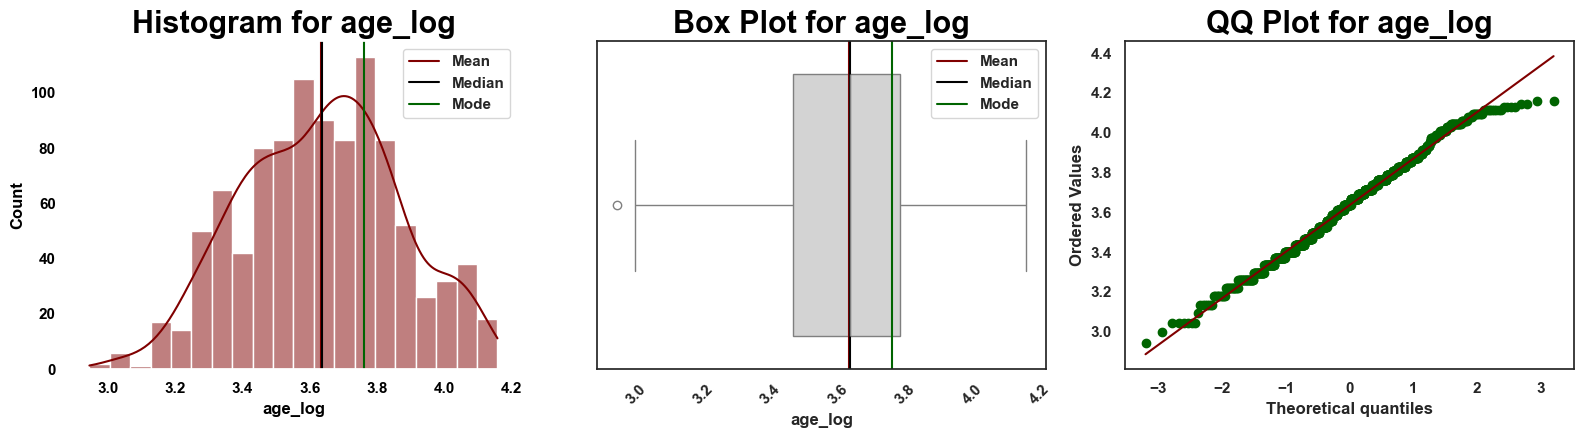



Skew for age_log is -0.04

Kurtosis for age_log is -0.48




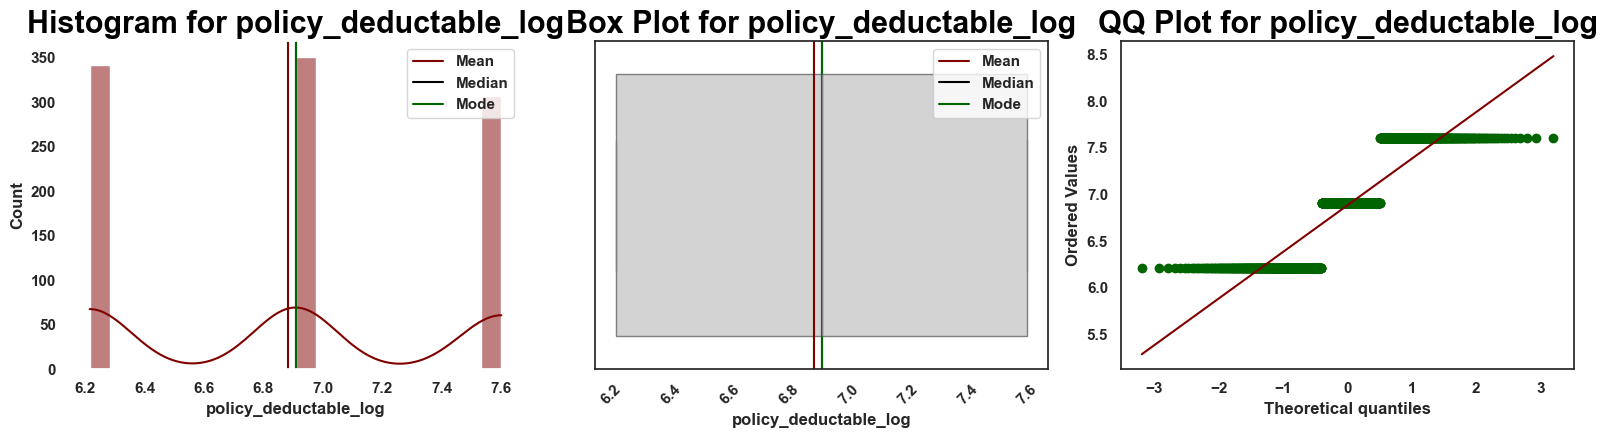



Skew for policy_deductable_log is 0.06

Kurtosis for policy_deductable_log is -1.45




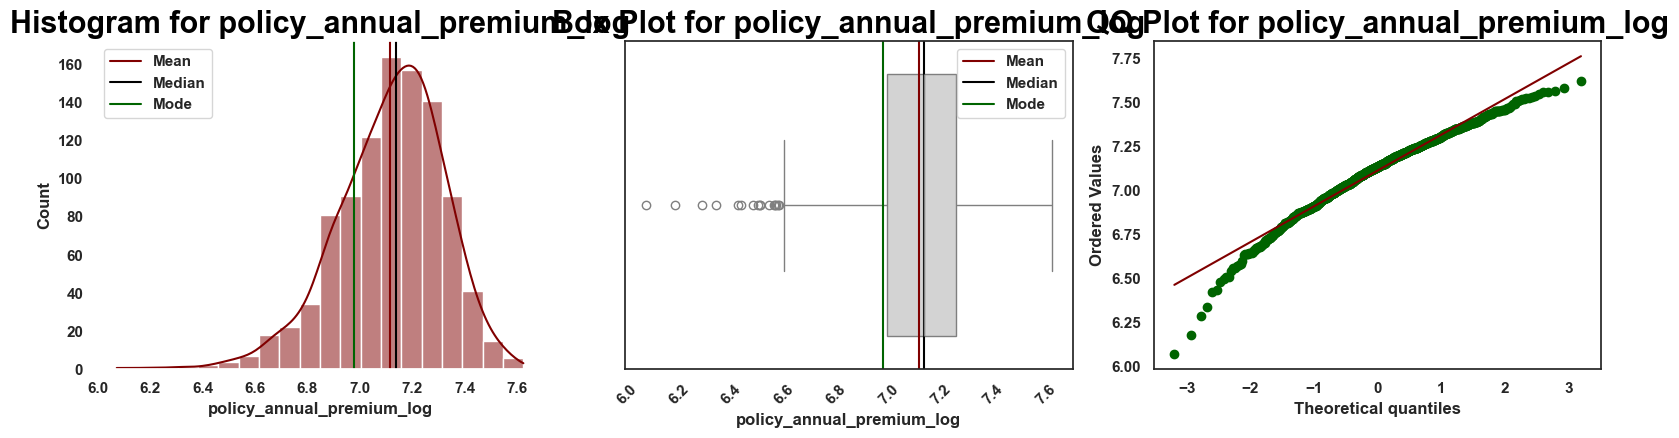



Skew for policy_annual_premium_log is -0.72

Kurtosis for policy_annual_premium_log is 1.31




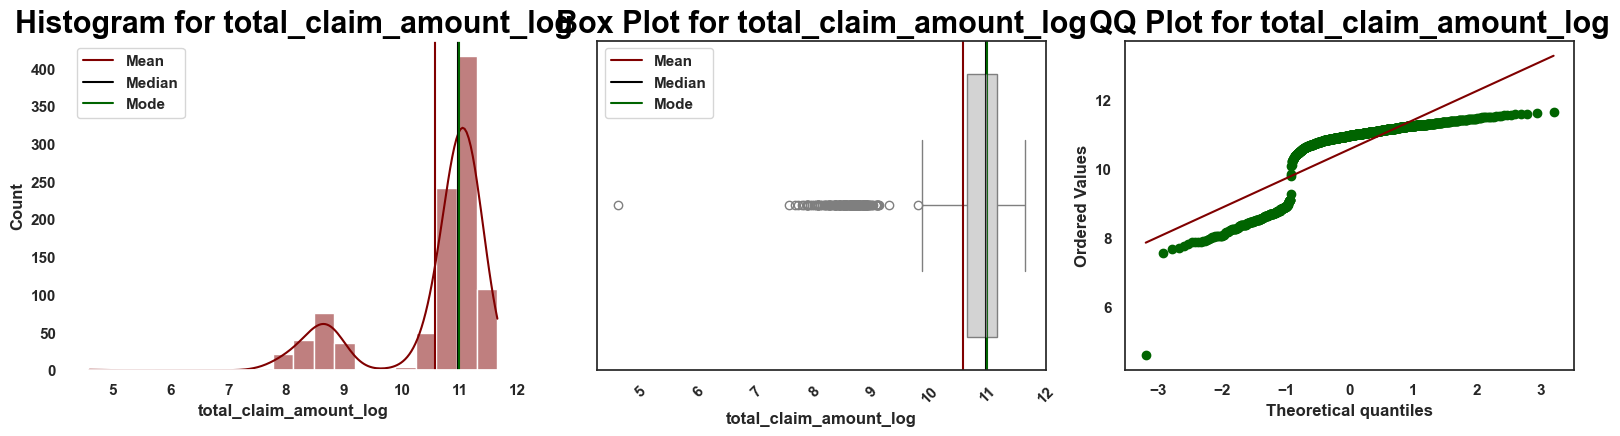



Skew for total_claim_amount_log is -1.66

Kurtosis for total_claim_amount_log is 1.86




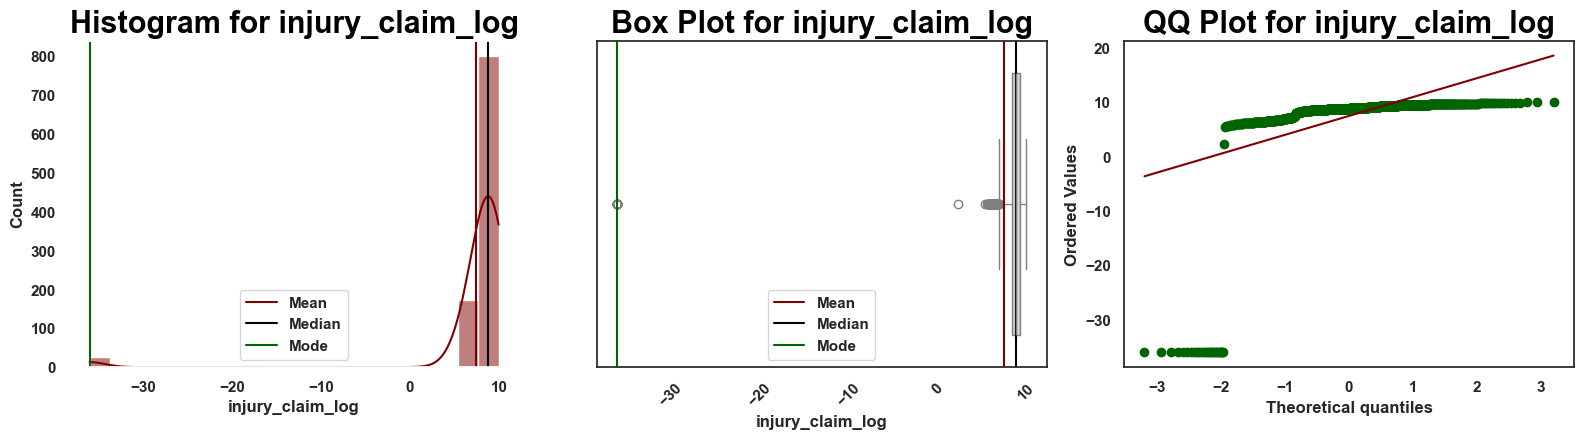



Skew for injury_claim_log is -5.89

Kurtosis for injury_claim_log is 33.54




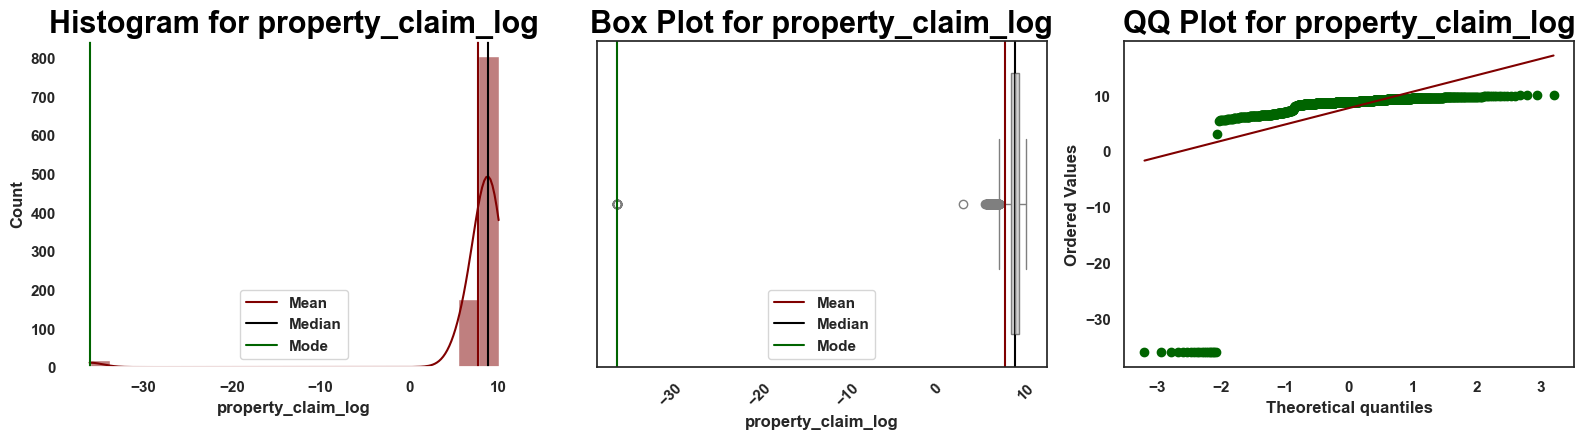



Skew for property_claim_log is -6.75

Kurtosis for property_claim_log is 45.03




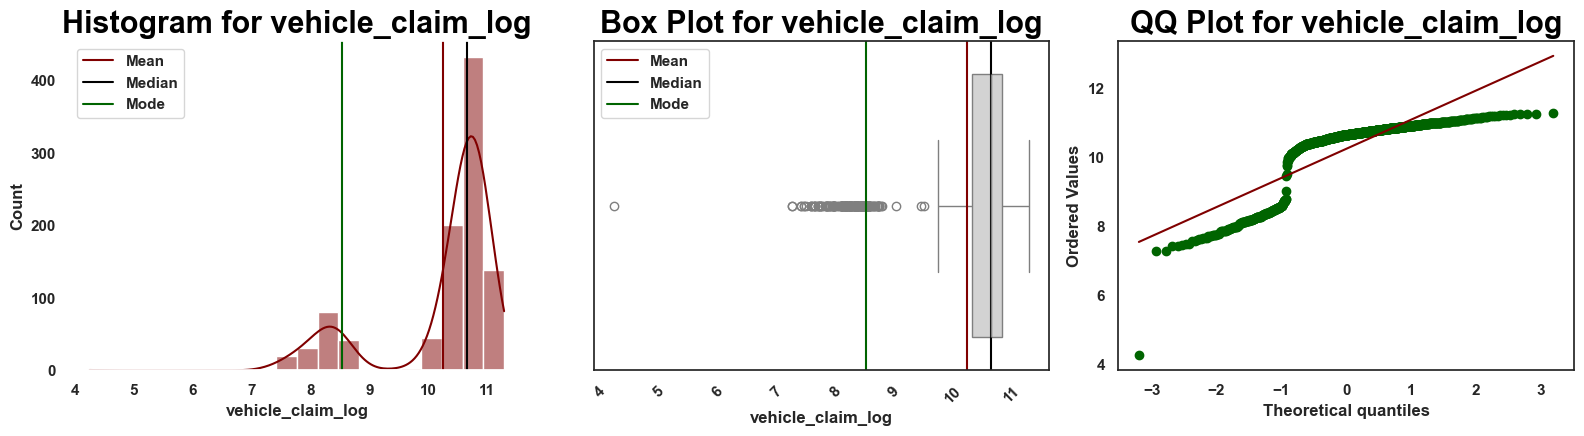



Skew for vehicle_claim_log is -1.67

Kurtosis for vehicle_claim_log is 1.91




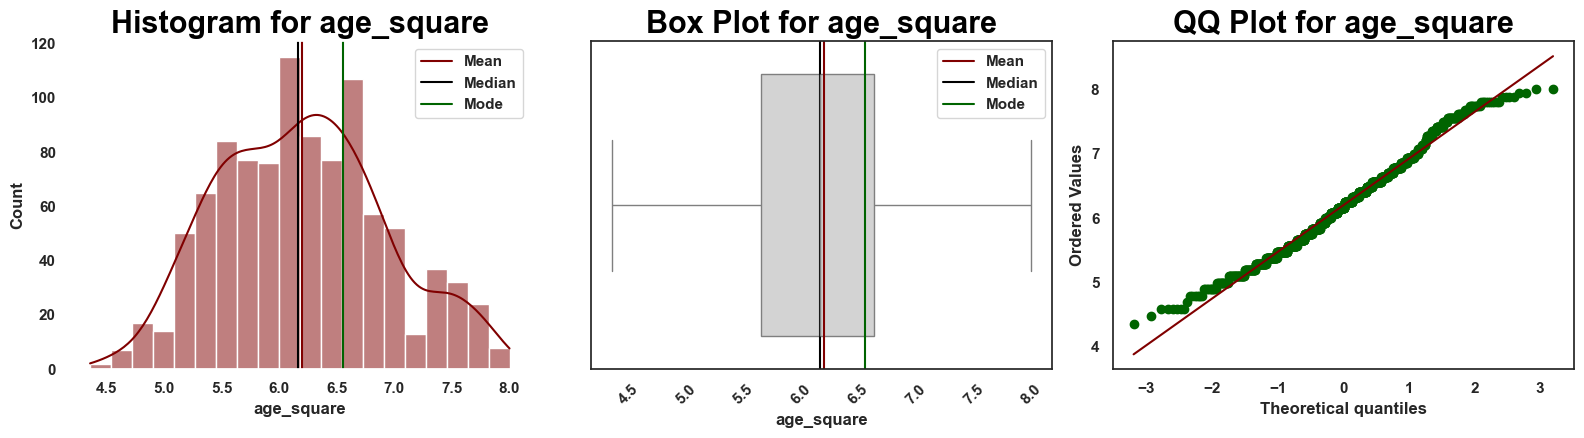

/home/san/mnt/F/Technology/Python Project/Capstone/Insurance_Analytics_Prediction/Insurance/lib/python3.12/site-packages/pandas/core/nanops.py:1353: RuntimeWarning: overflow encountered in scalar power
  adj = 3 * (count - 1) ** 2 / ((count - 2) * (count - 3))
/home/san/mnt/F/Technology/Python Project/Capstone/Insurance_Analytics_Prediction/Insurance/lib/python3.12/site-packages/pandas/core/nanops.py:1353: RuntimeWarning: overflow encountered in scalar multiply
  adj = 3 * (count - 1) ** 2 / ((count - 2) * (count - 3))
/home/san/mnt/F/Technology/Python Project/Capstone/Insurance_Analytics_Prediction/Insurance/lib/python3.12/site-packages/pandas/core/nanops.py:1354: RuntimeWarning: overflow encountered in scalar multiply
  numerator = count * (count + 1) * (count - 1) * m4
/home/san/mnt/F/Technology/Python Project/Capstone/Insurance_Analytics_Prediction/Insurance/lib/python3.12/site-packages/pandas/core/nanops.py:1355: RuntimeWarning: overflow encountered in scalar multiply
  denominato



Skew for age_square is 0.22

Kurtosis for age_square is nan




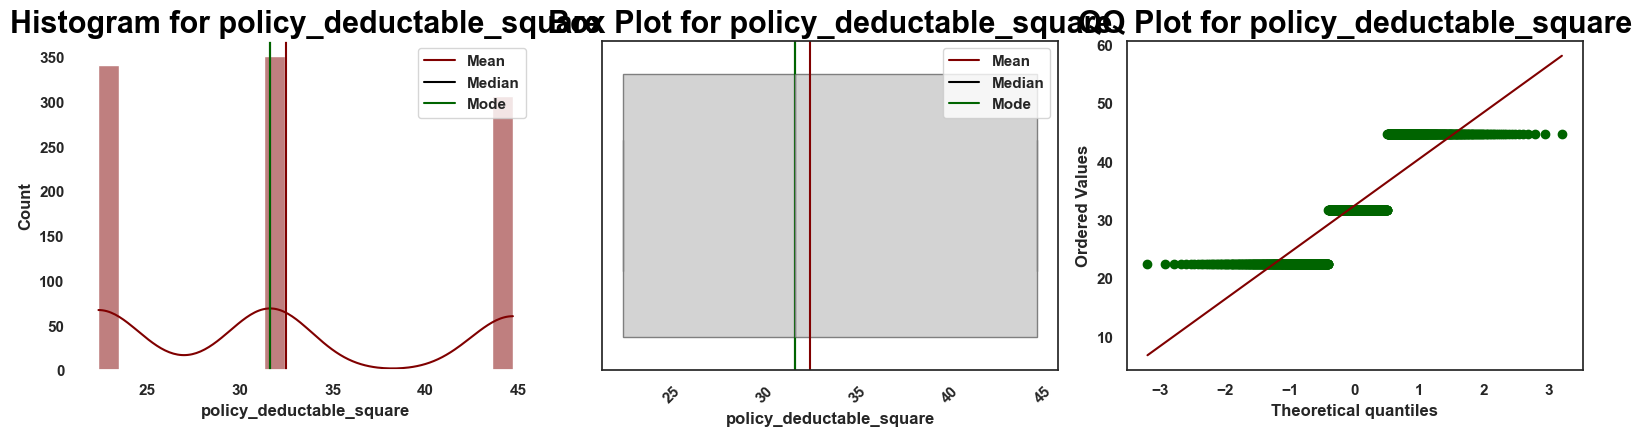



Skew for policy_deductable_square is 0.29

Kurtosis for policy_deductable_square is -1.41




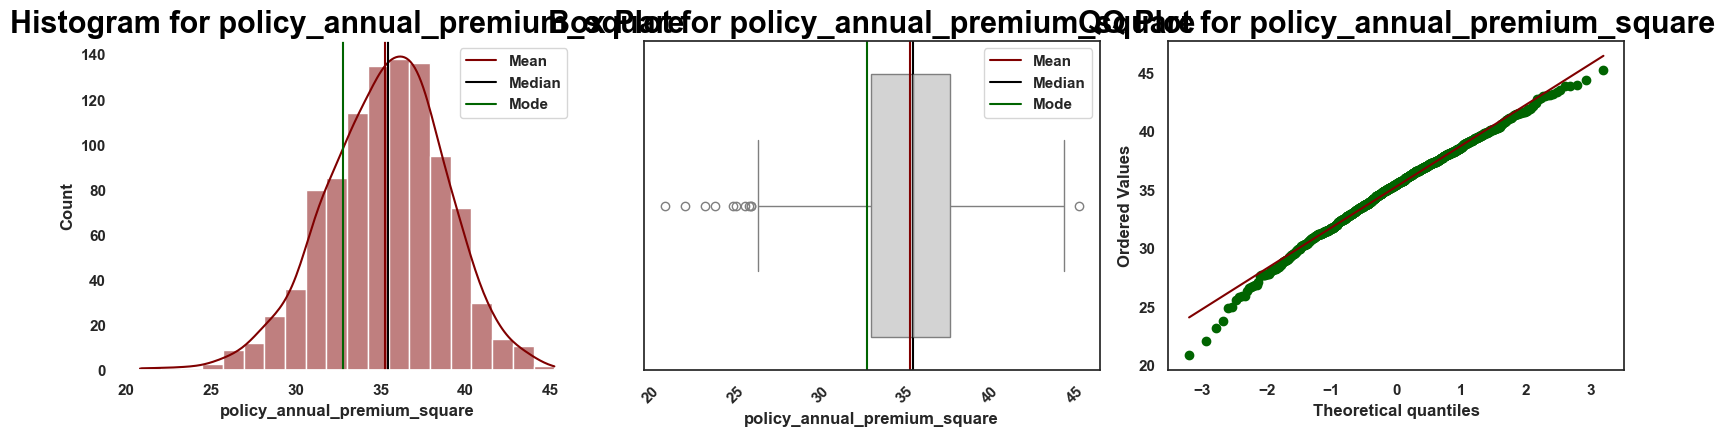



Skew for policy_annual_premium_square is -0.33

Kurtosis for policy_annual_premium_square is 0.39




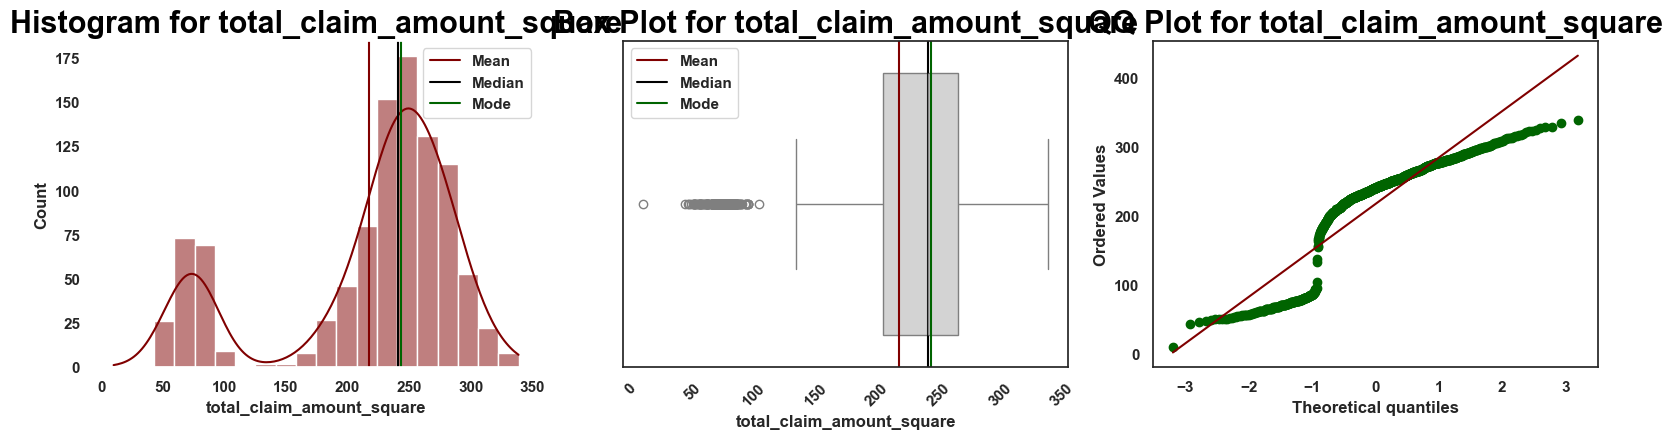



Skew for total_claim_amount_square is -1.13

Kurtosis for total_claim_amount_square is 0.06




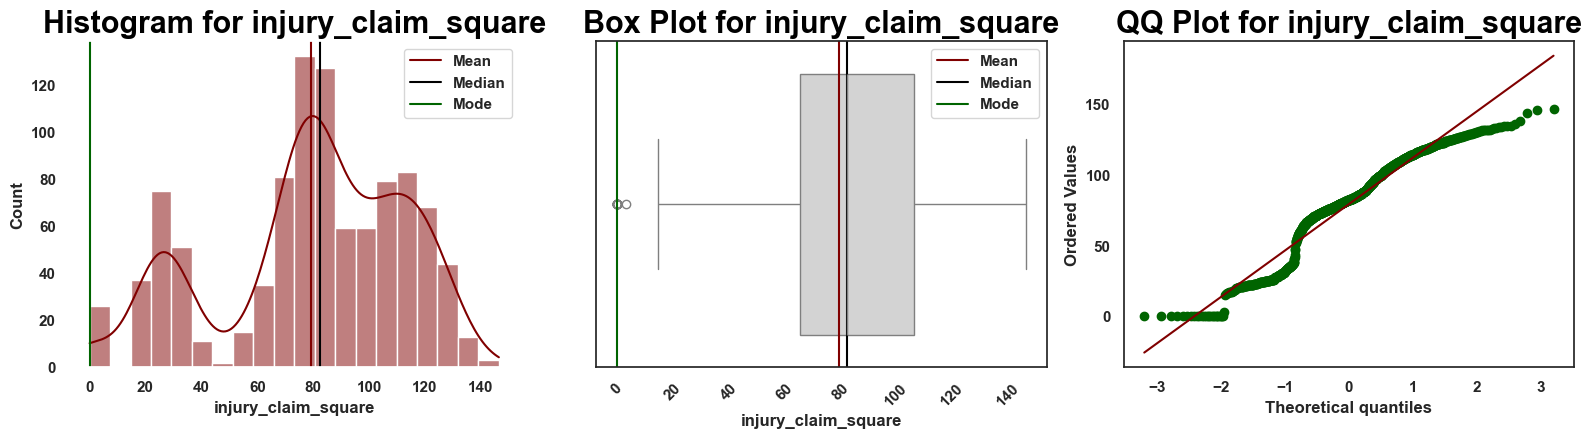



Skew for injury_claim_square is -0.55

Kurtosis for injury_claim_square is -0.49




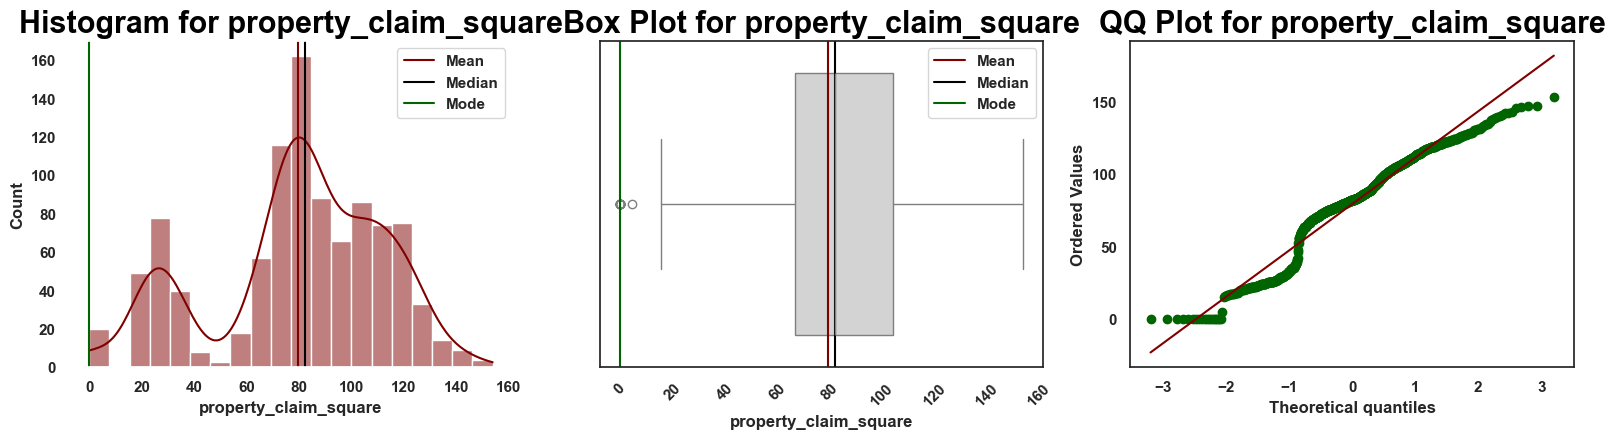



Skew for property_claim_square is -0.52

Kurtosis for property_claim_square is -0.39




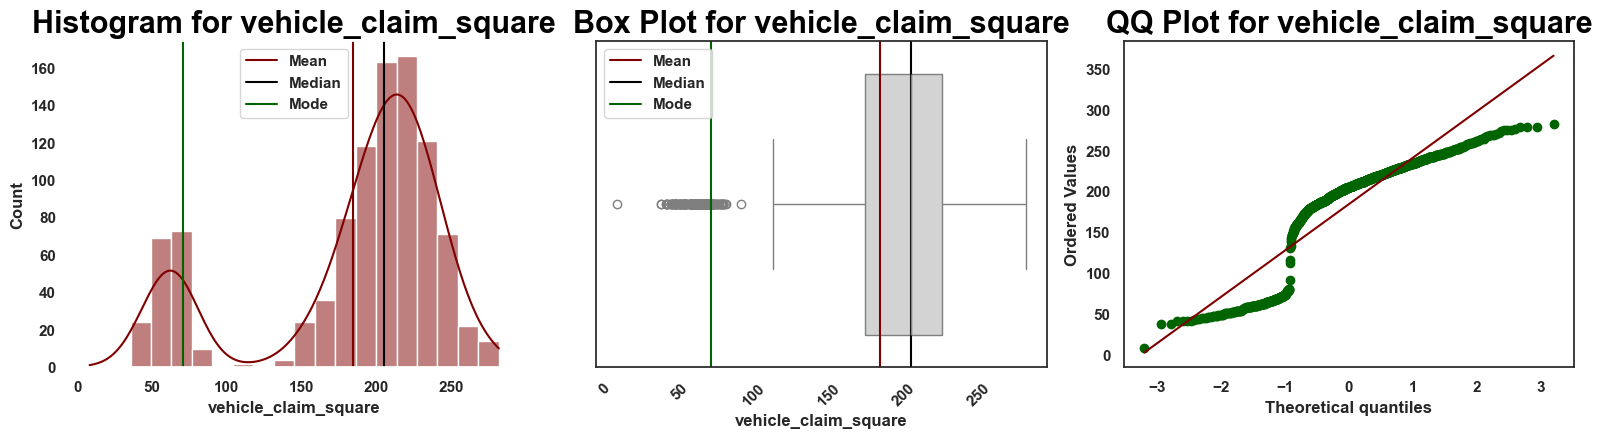



Skew for vehicle_claim_square is -1.15

Kurtosis for vehicle_claim_square is 0.08




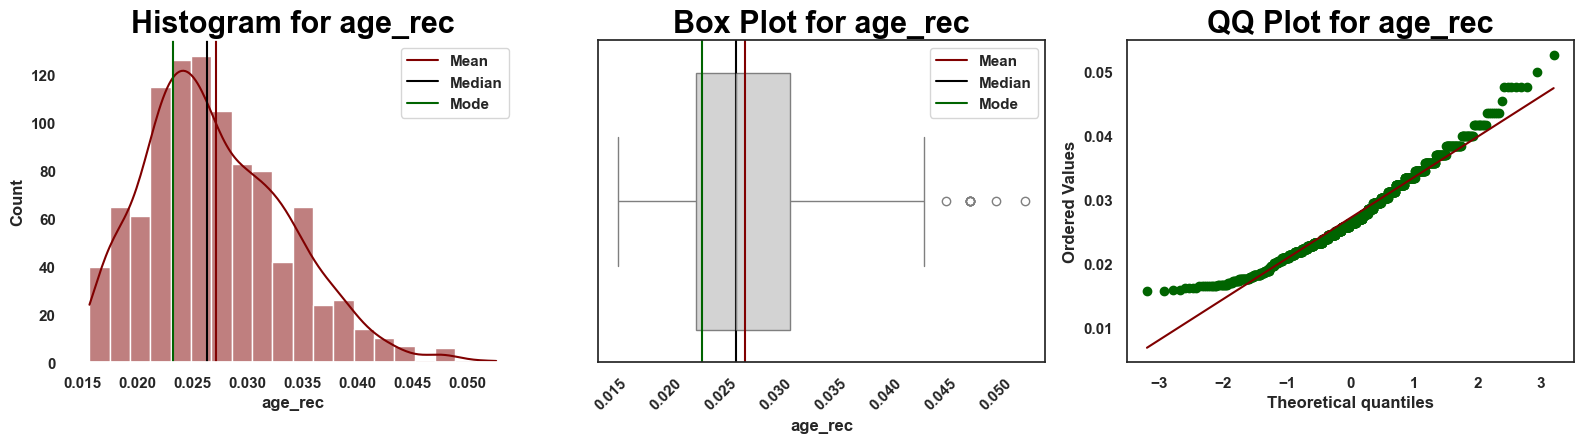



Skew for age_rec is 0.60

Kurtosis for age_rec is 0.15




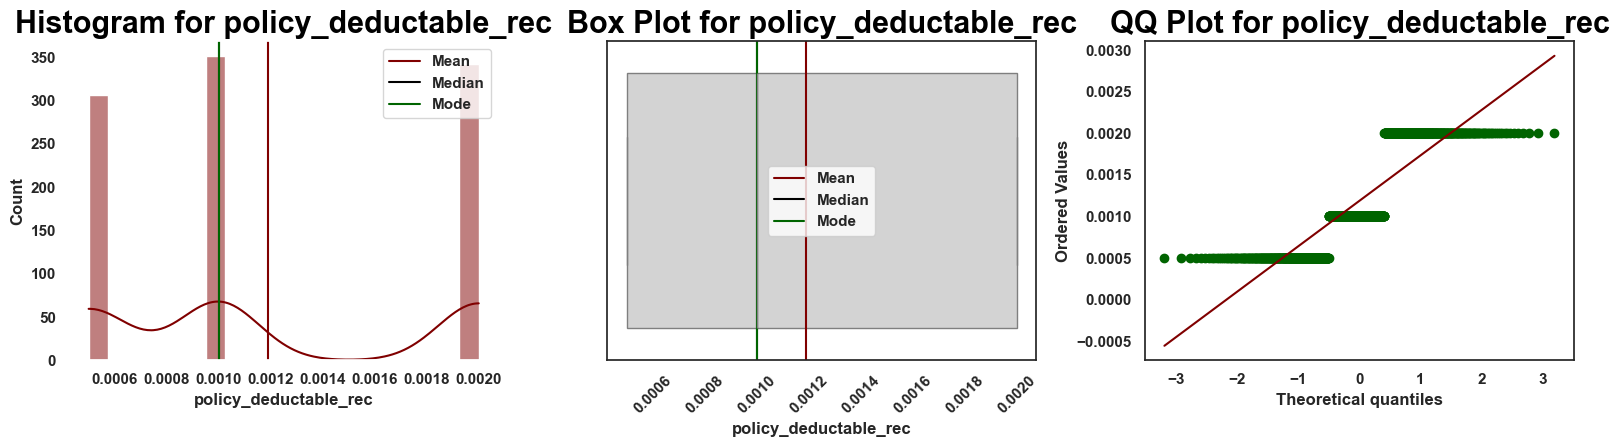



Skew for policy_deductable_rec is 0.34

Kurtosis for policy_deductable_rec is -1.52




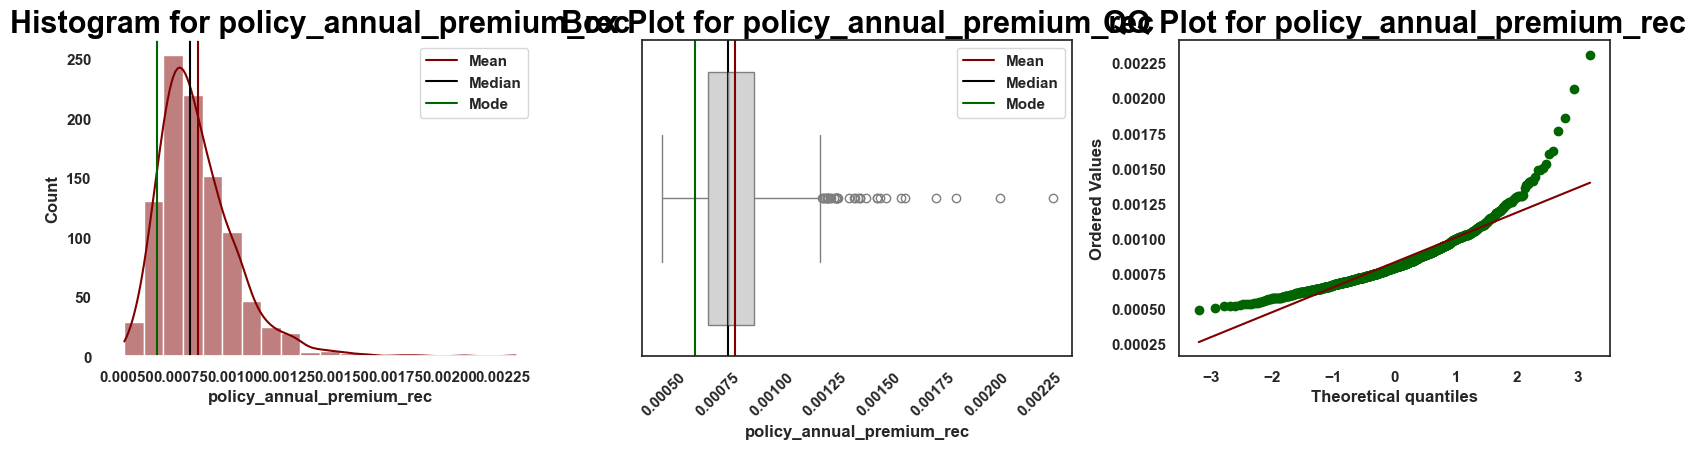



Skew for policy_annual_premium_rec is 1.86

Kurtosis for policy_annual_premium_rec is 7.53




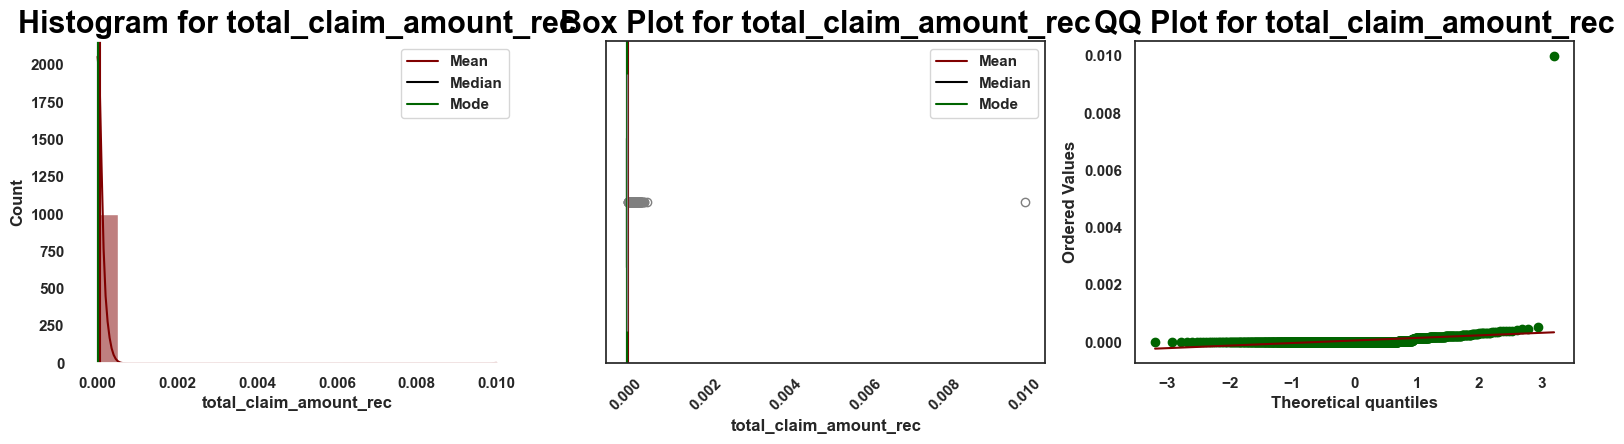



Skew for total_claim_amount_rec is 28.89

Kurtosis for total_claim_amount_rec is 885.00




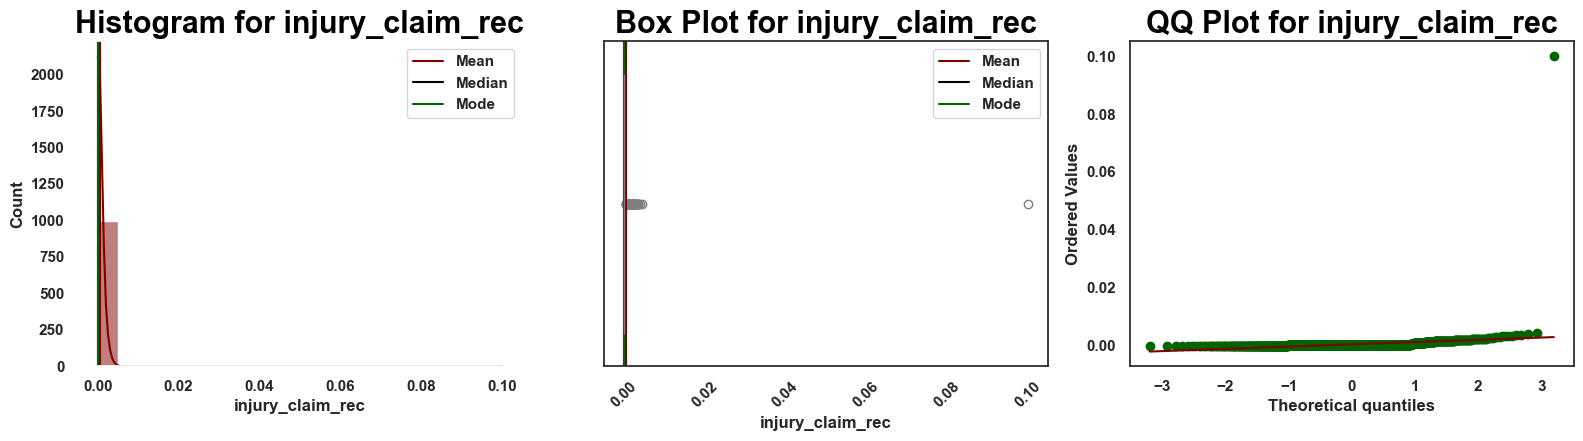



Skew for injury_claim_rec is 29.87

Kurtosis for injury_claim_rec is 925.85




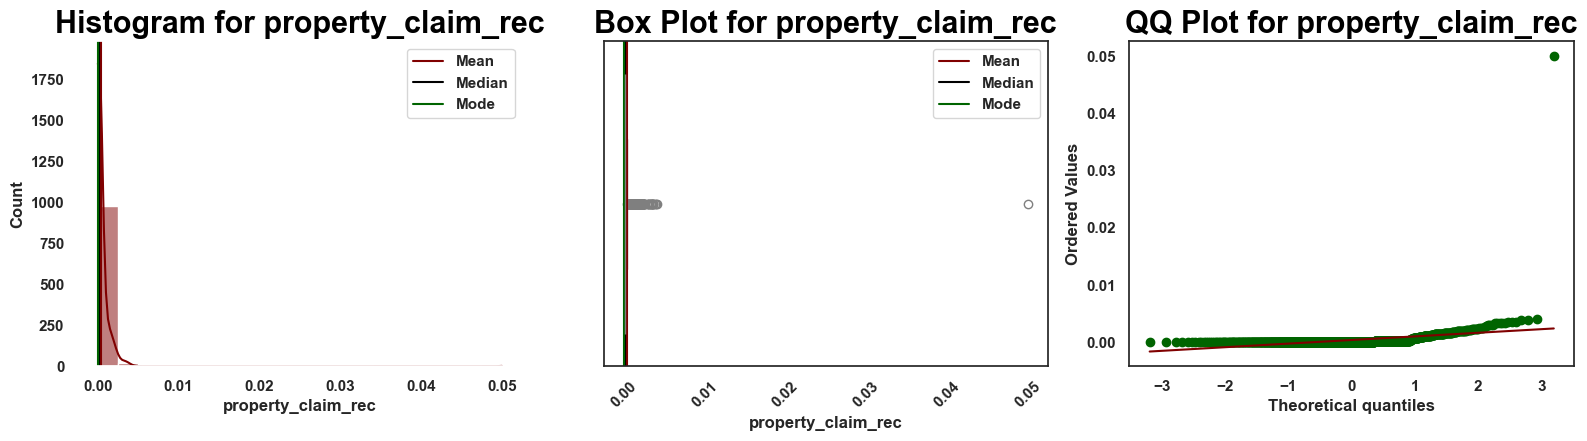



Skew for property_claim_rec is 25.16

Kurtosis for property_claim_rec is 731.09




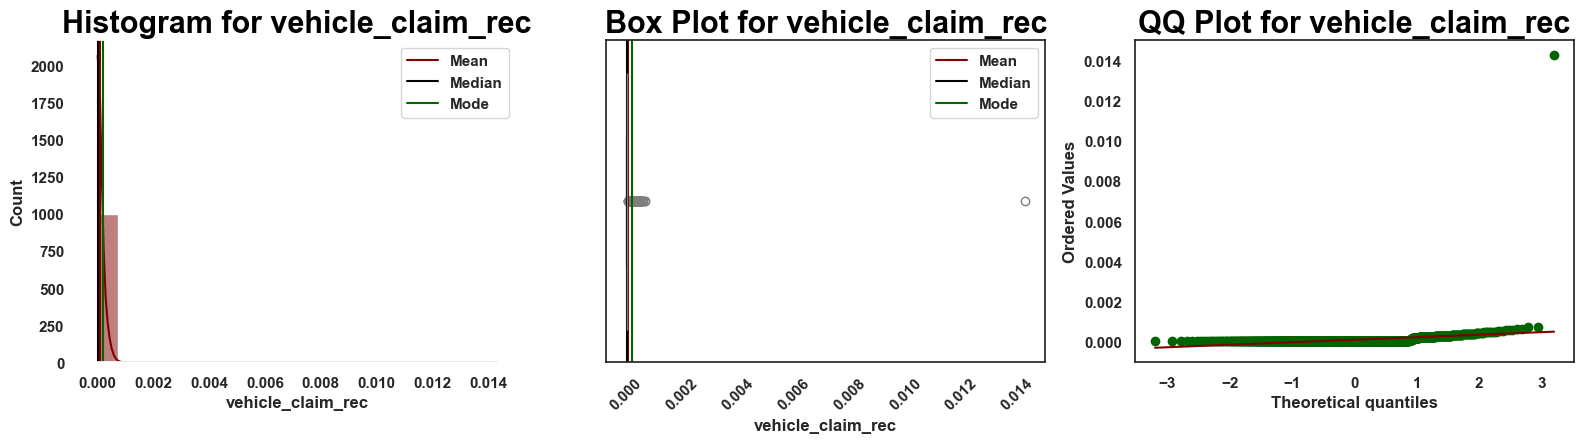



Skew for vehicle_claim_rec is 29.01

Kurtosis for vehicle_claim_rec is 889.83




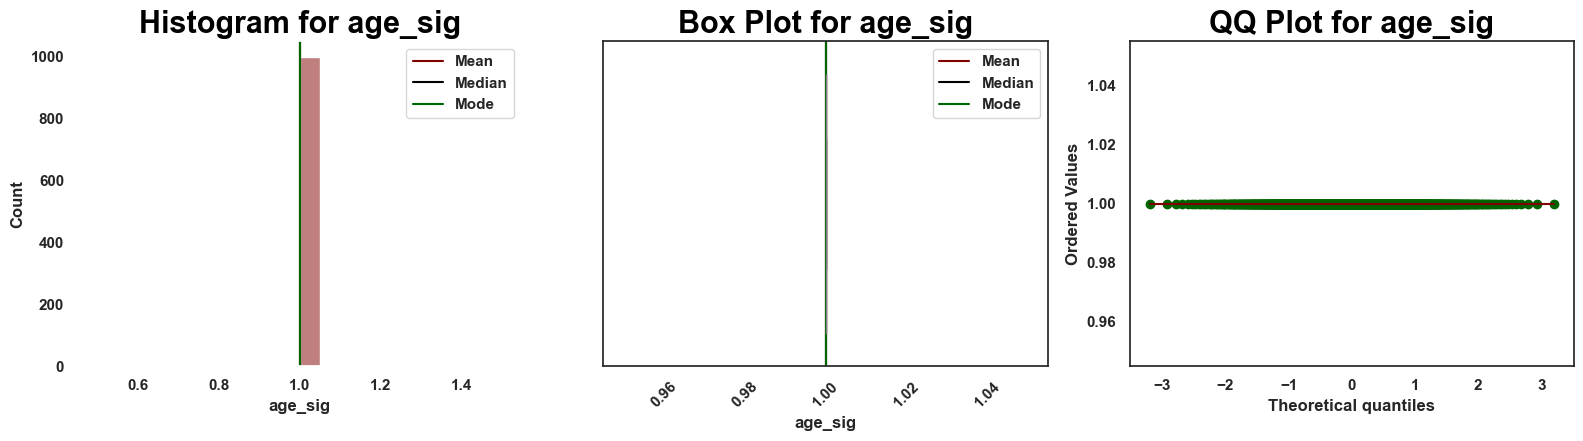

/home/san/mnt/F/Technology/Python Project/Capstone/Insurance_Analytics_Prediction/Insurance/lib/python3.12/site-packages/pandas/core/nanops.py:1353: RuntimeWarning: overflow encountered in scalar power
  adj = 3 * (count - 1) ** 2 / ((count - 2) * (count - 3))
/home/san/mnt/F/Technology/Python Project/Capstone/Insurance_Analytics_Prediction/Insurance/lib/python3.12/site-packages/pandas/core/nanops.py:1353: RuntimeWarning: overflow encountered in scalar multiply
  adj = 3 * (count - 1) ** 2 / ((count - 2) * (count - 3))
/home/san/mnt/F/Technology/Python Project/Capstone/Insurance_Analytics_Prediction/Insurance/lib/python3.12/site-packages/pandas/core/nanops.py:1354: RuntimeWarning: overflow encountered in scalar multiply
  numerator = count * (count + 1) * (count - 1) * m4
/home/san/mnt/F/Technology/Python Project/Capstone/Insurance_Analytics_Prediction/Insurance/lib/python3.12/site-packages/pandas/core/nanops.py:1355: RuntimeWarning: overflow encountered in scalar multiply
  denominato



Skew for age_sig is 0.00

Kurtosis for age_sig is nan




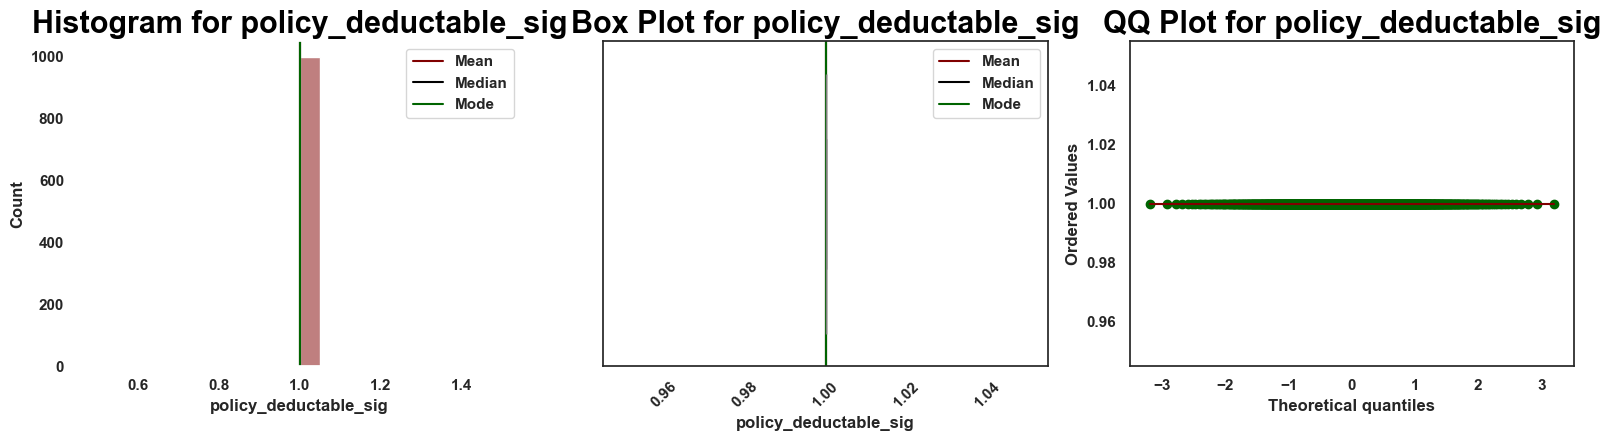



Skew for policy_deductable_sig is 0.00

Kurtosis for policy_deductable_sig is 0.00




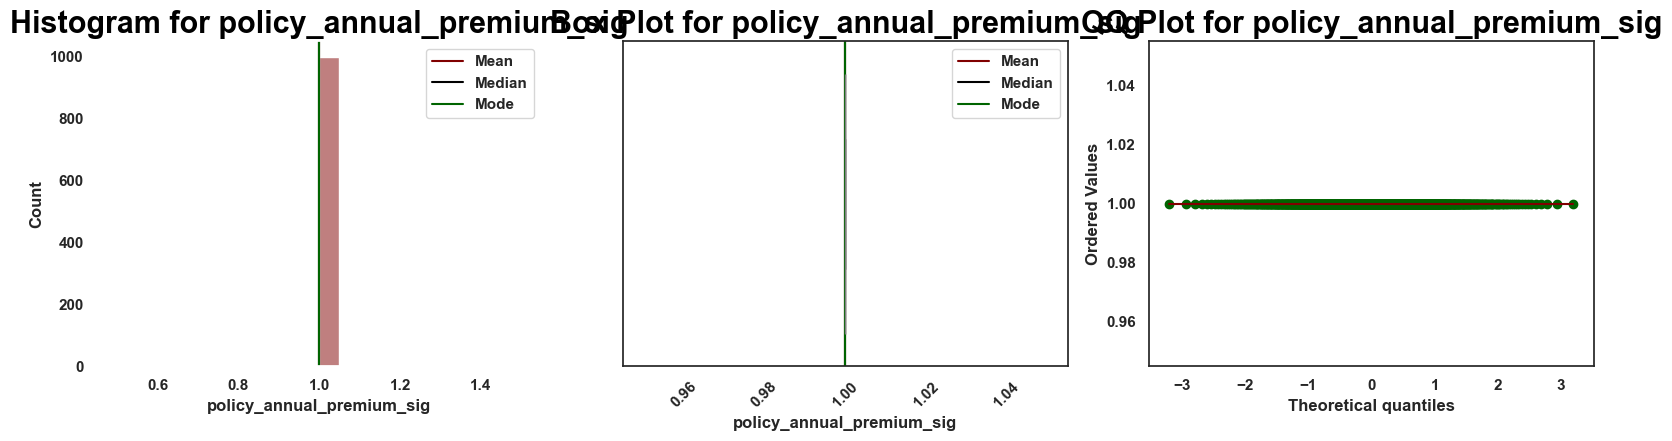



Skew for policy_annual_premium_sig is 0.00

Kurtosis for policy_annual_premium_sig is 0.00




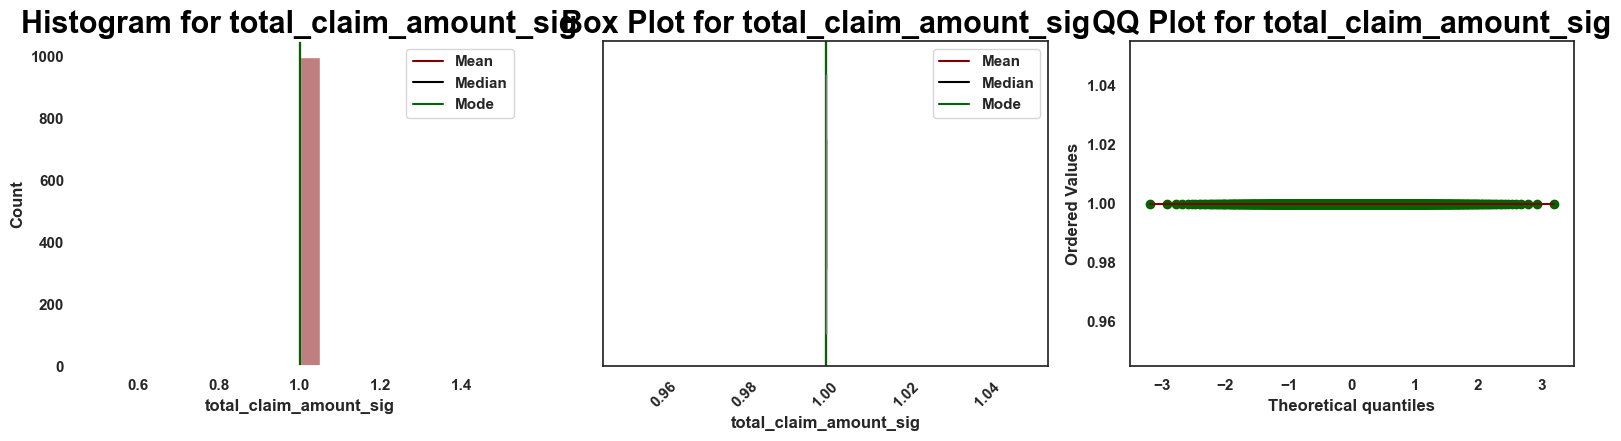



Skew for total_claim_amount_sig is 0.00

Kurtosis for total_claim_amount_sig is 0.00




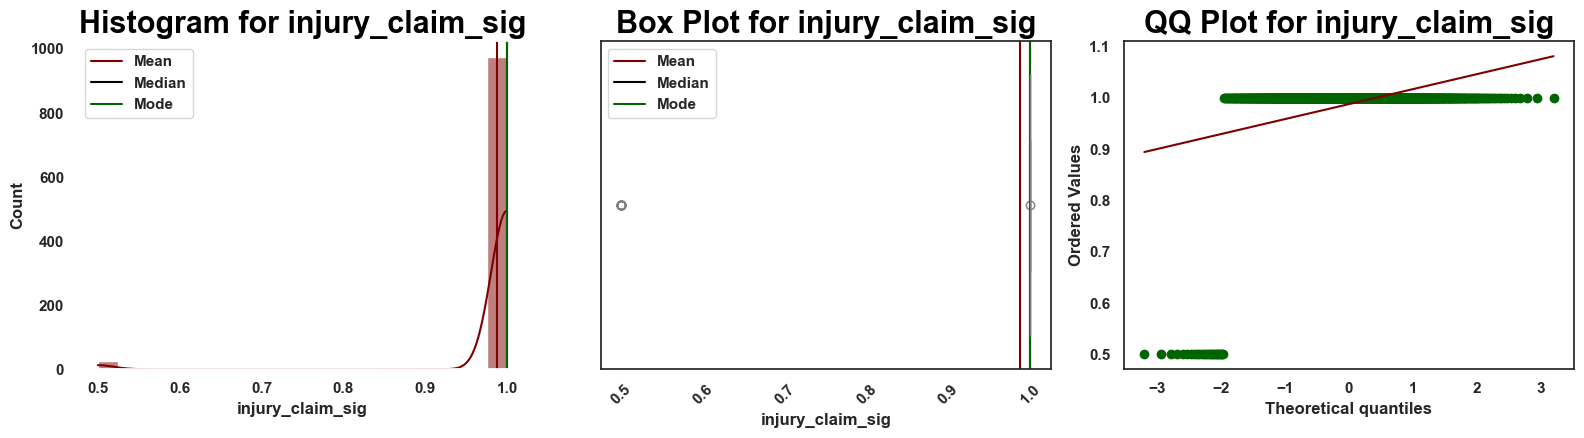



Skew for injury_claim_sig is -6.09

Kurtosis for injury_claim_sig is 35.21




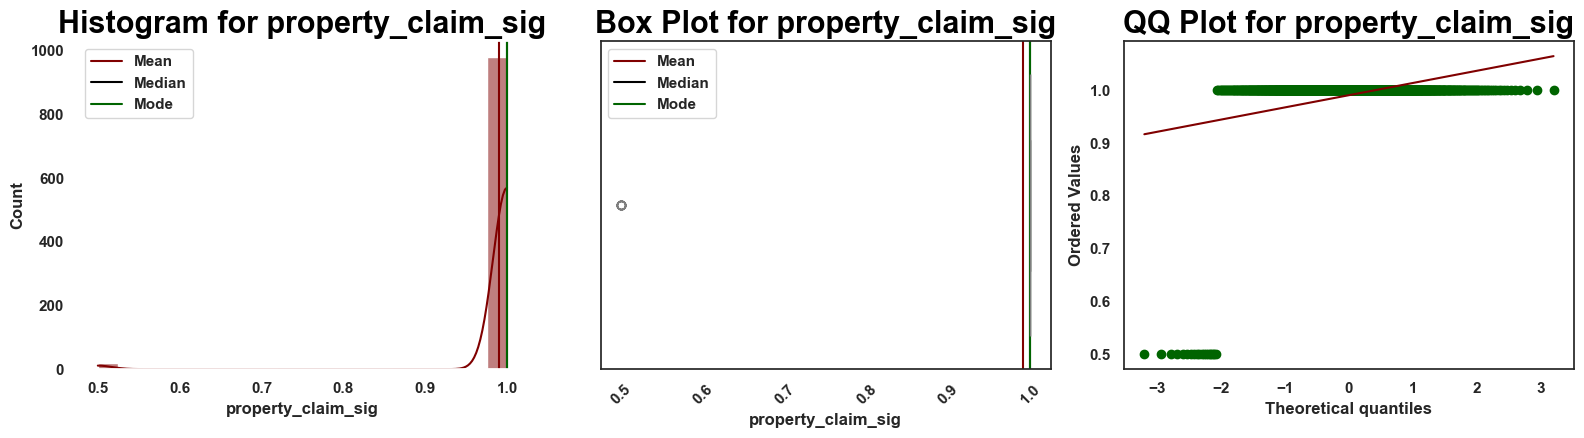



Skew for property_claim_sig is -7.06

Kurtosis for property_claim_sig is 47.90




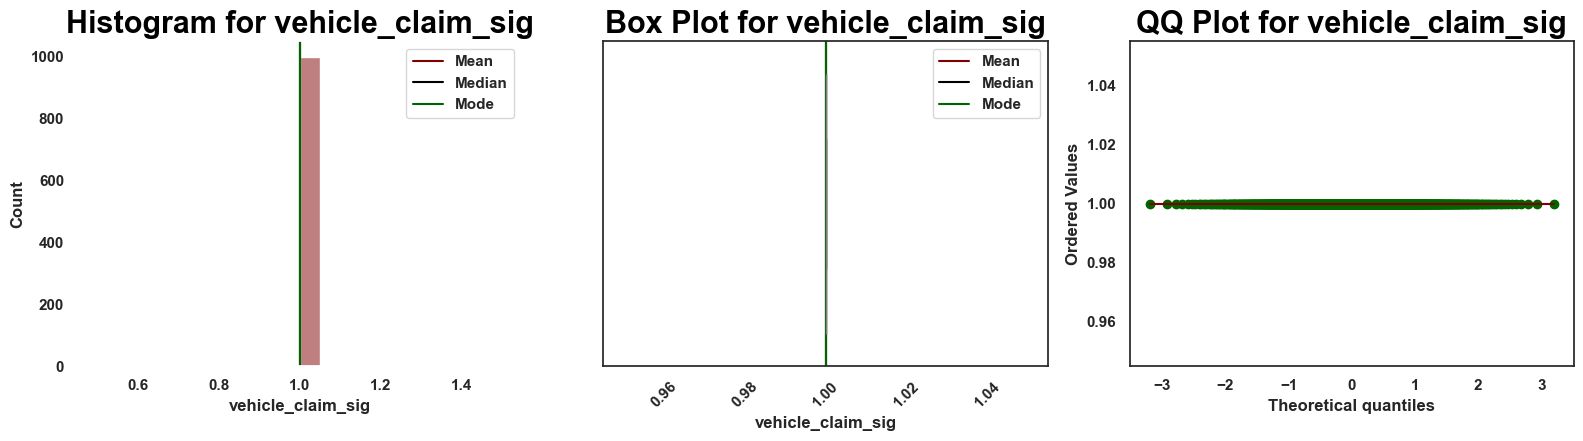



Skew for vehicle_claim_sig is 0.00

Kurtosis for vehicle_claim_sig is 0.00




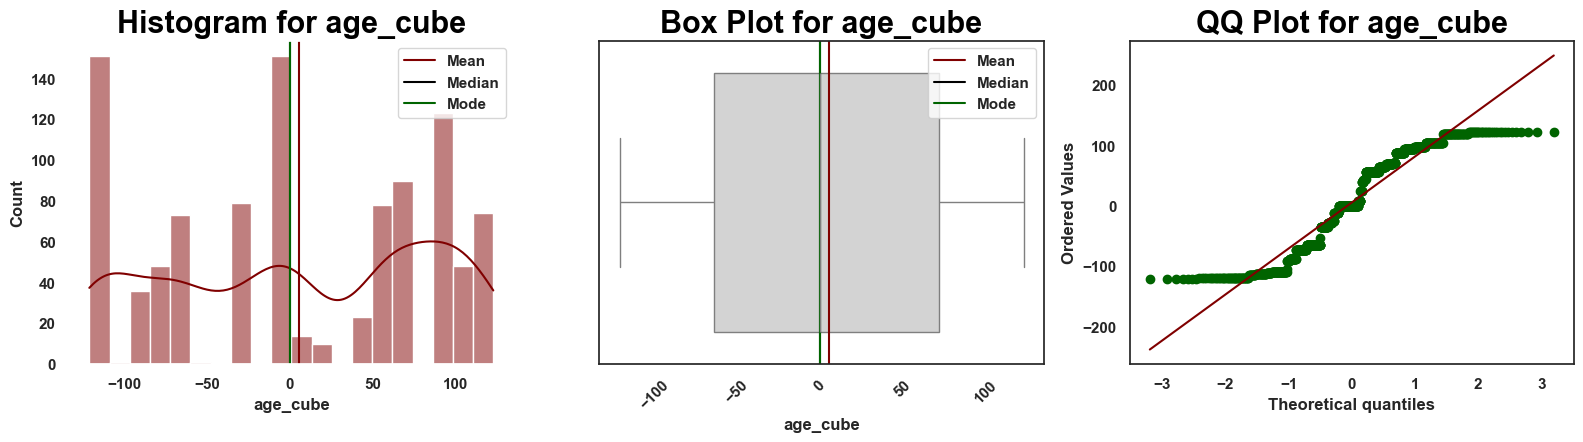



Skew for age_cube is -0.14

Kurtosis for age_cube is -1.34




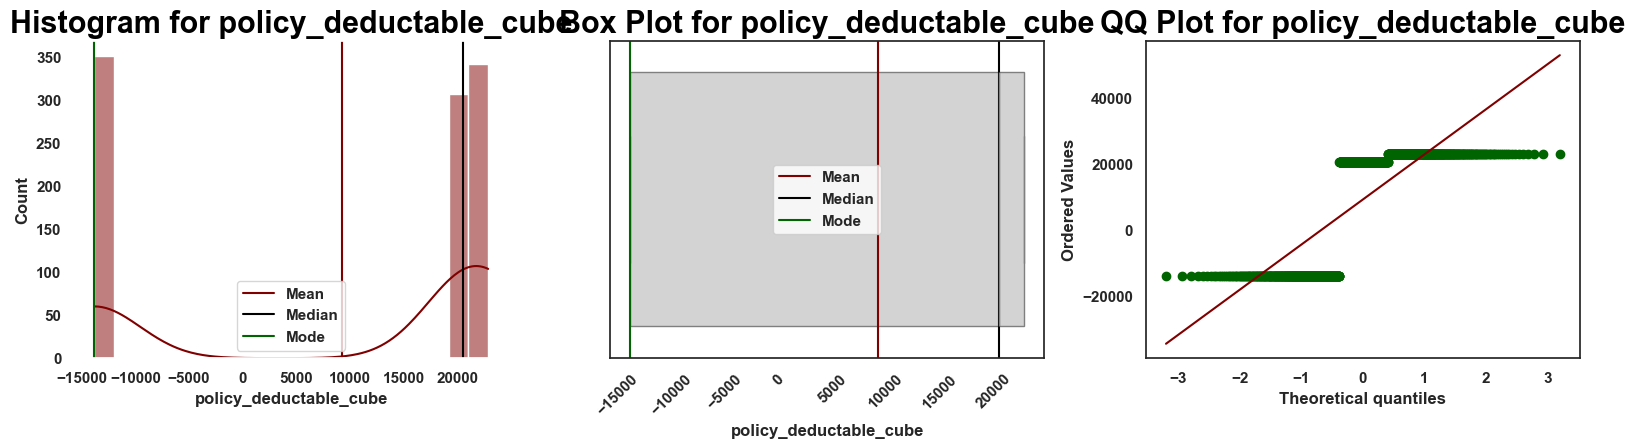



Skew for policy_deductable_cube is -0.62

Kurtosis for policy_deductable_cube is -1.61




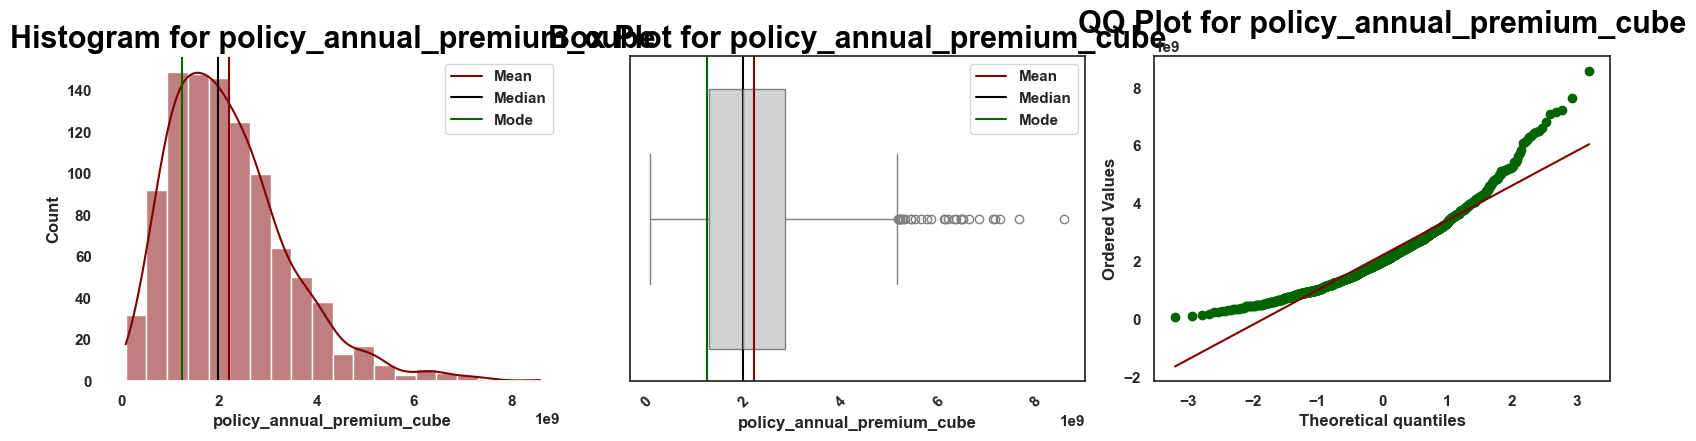



Skew for policy_annual_premium_cube is 1.17

Kurtosis for policy_annual_premium_cube is 2.04




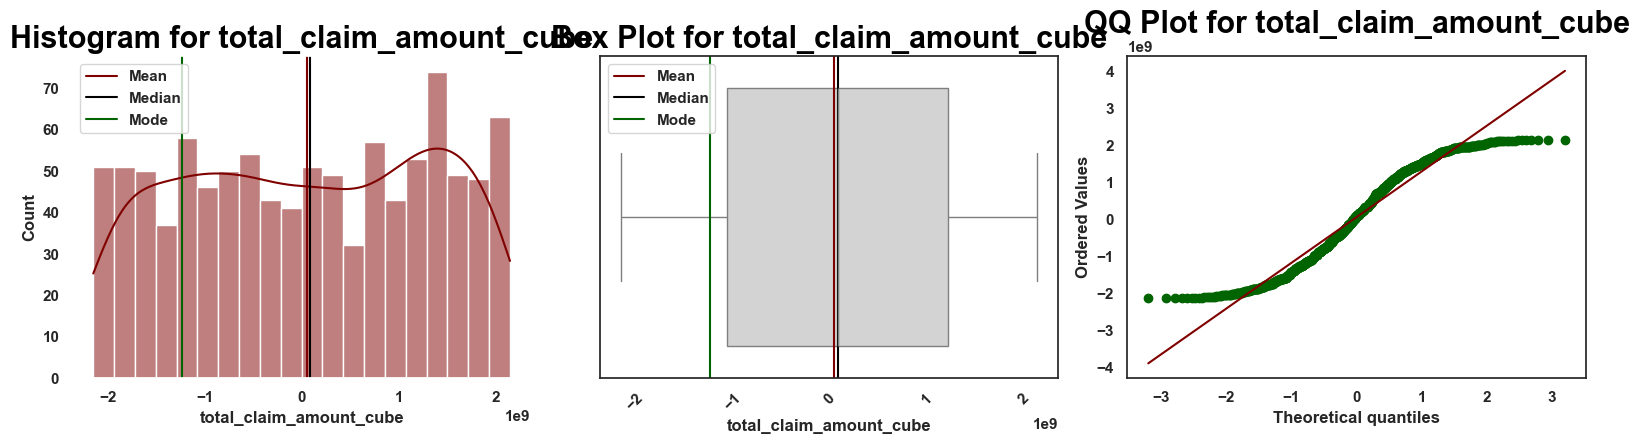



Skew for total_claim_amount_cube is -0.05

Kurtosis for total_claim_amount_cube is -1.25




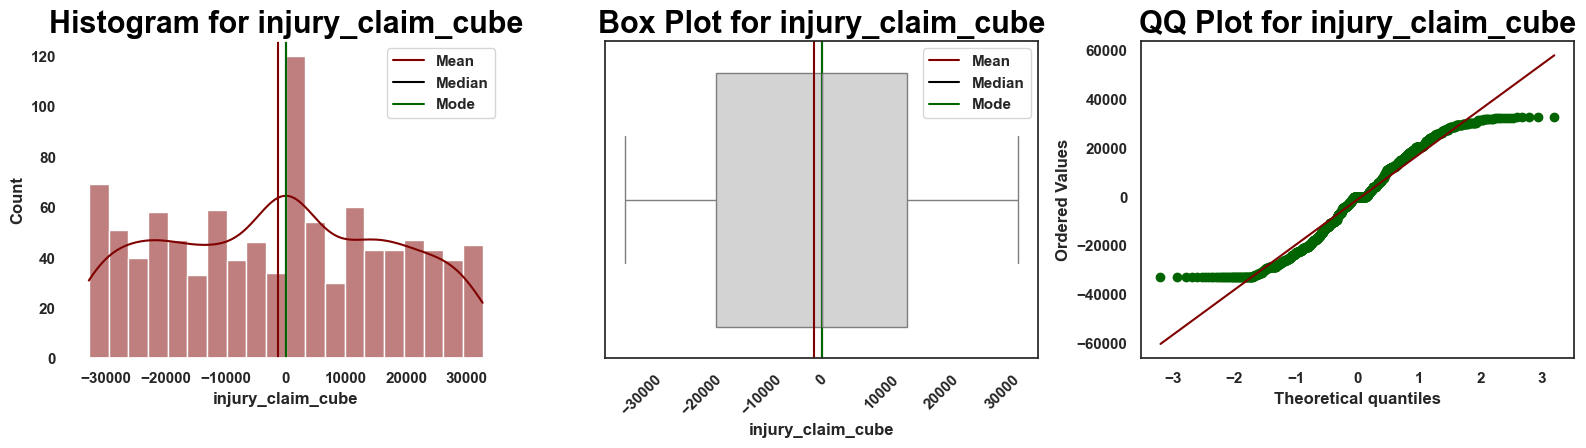



Skew for injury_claim_cube is 0.01

Kurtosis for injury_claim_cube is -1.07




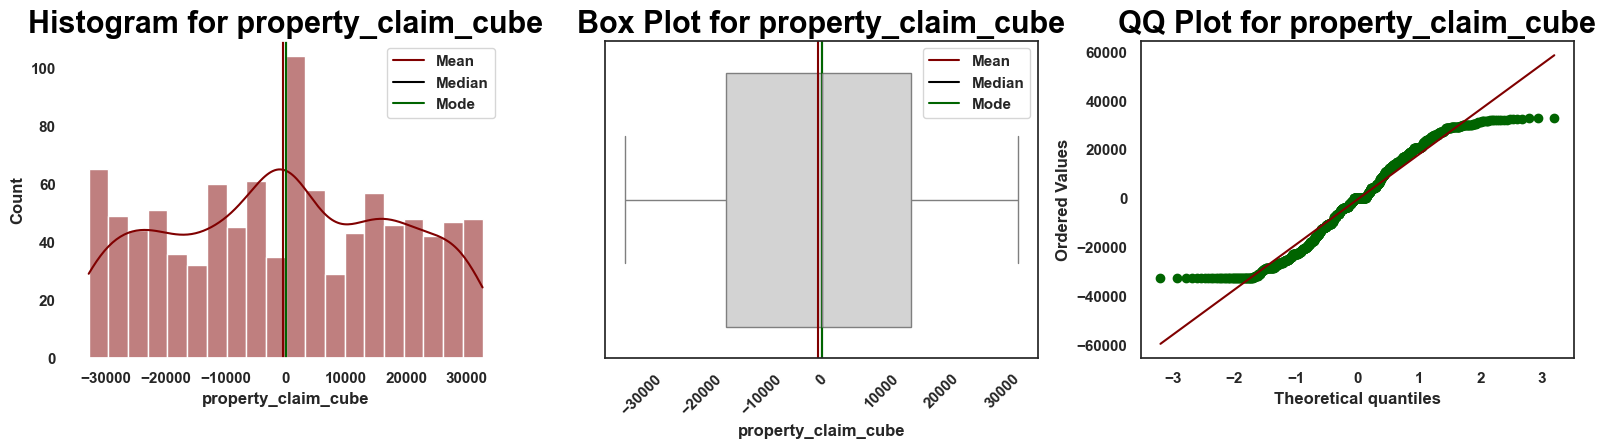



Skew for property_claim_cube is -0.02

Kurtosis for property_claim_cube is -1.06




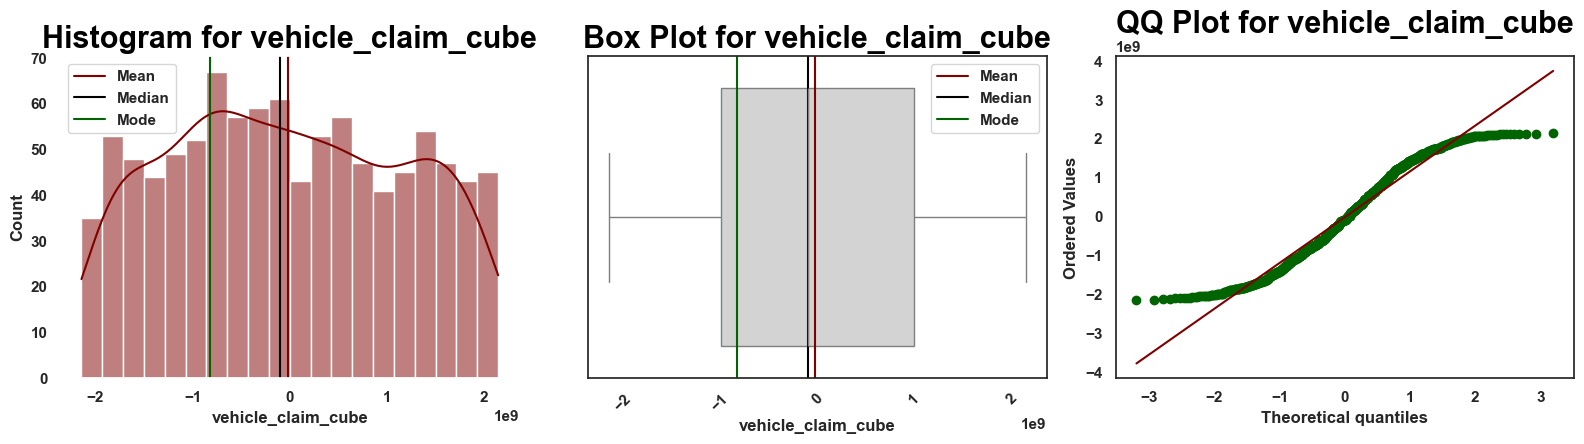



Skew for vehicle_claim_cube is 0.06

Kurtosis for vehicle_claim_cube is -1.12




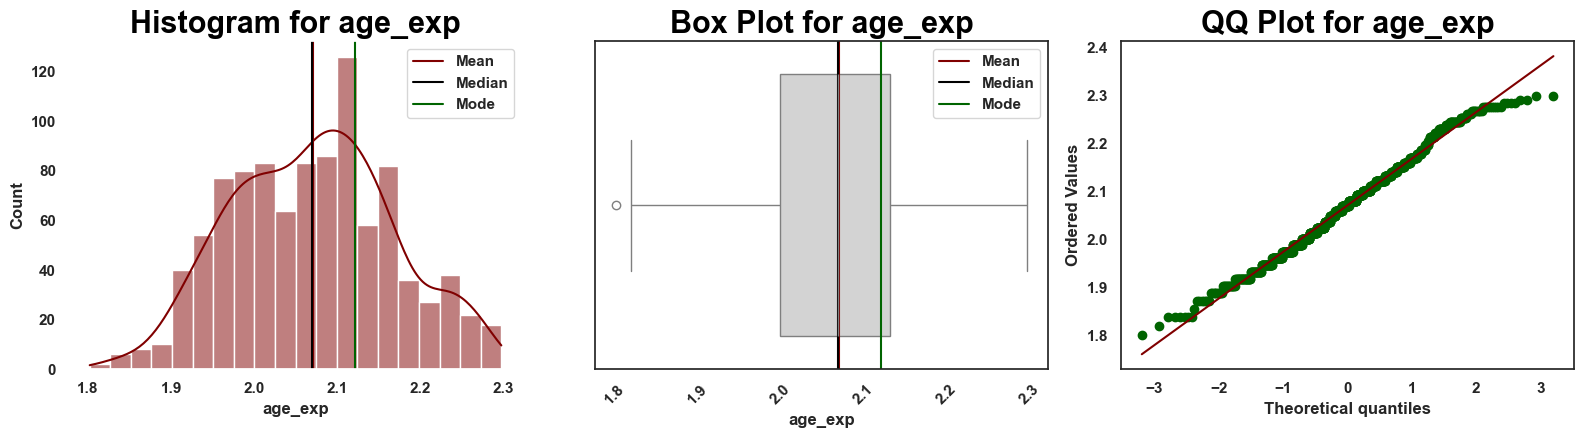



Skew for age_exp is 0.06

Kurtosis for age_exp is -0.49




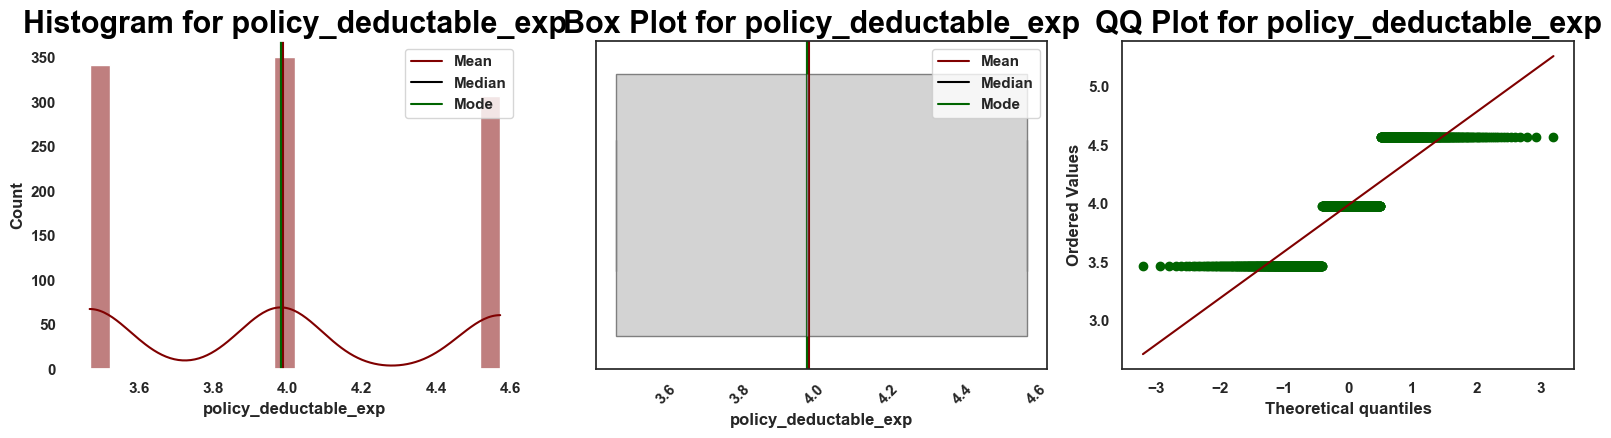



Skew for policy_deductable_exp is 0.15

Kurtosis for policy_deductable_exp is -1.44




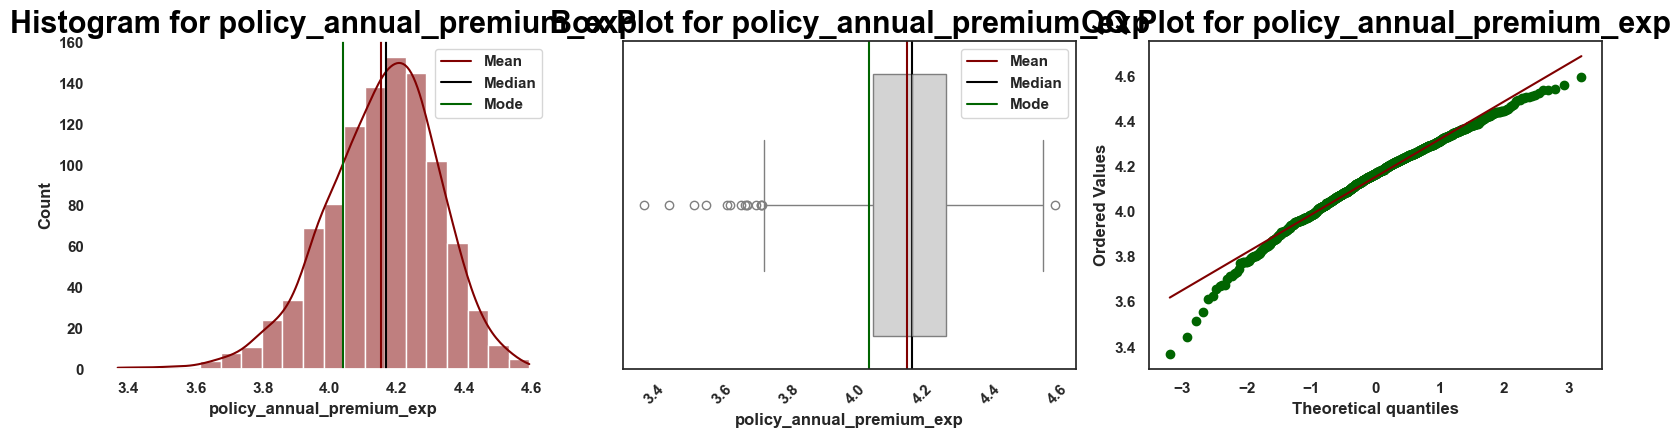



Skew for policy_annual_premium_exp is -0.55

Kurtosis for policy_annual_premium_exp is 0.85




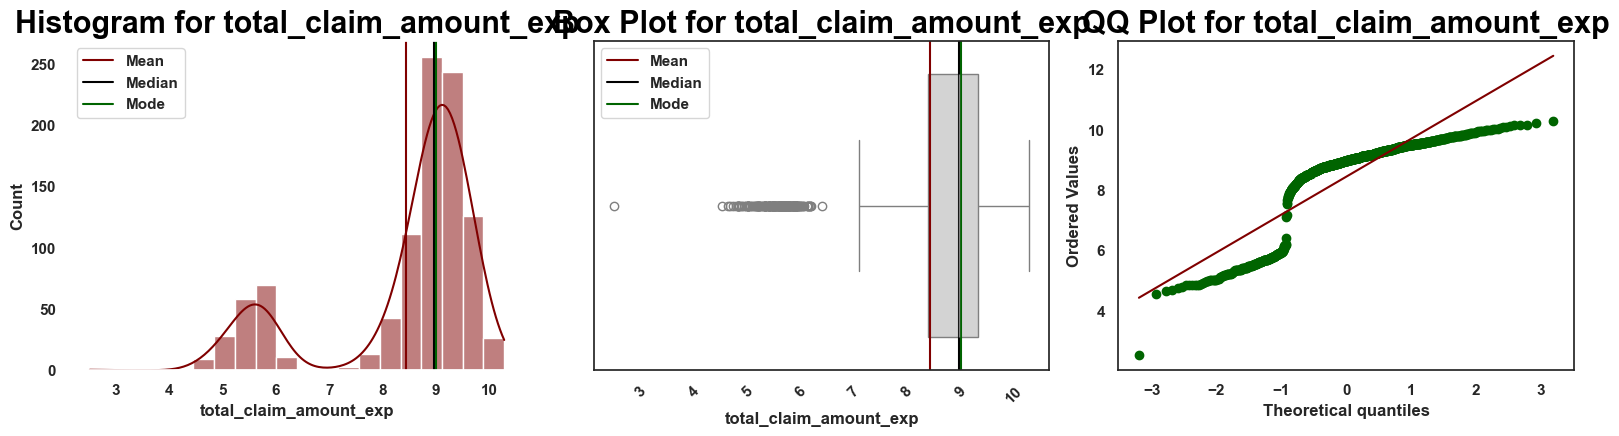



Skew for total_claim_amount_exp is -1.42

Kurtosis for total_claim_amount_exp is 0.67




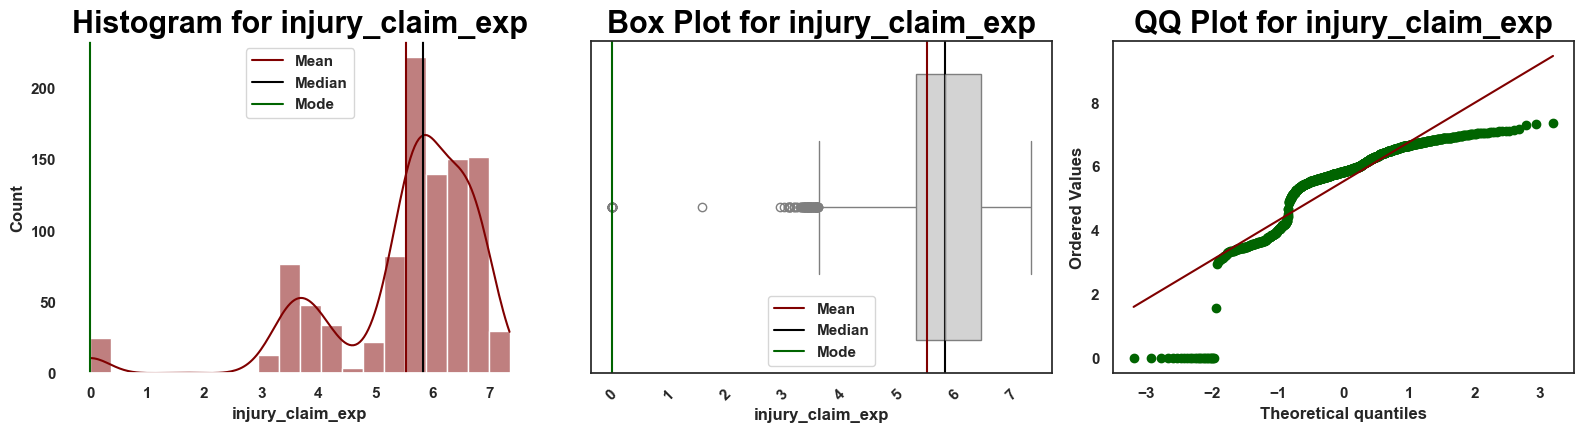



Skew for injury_claim_exp is -1.92

Kurtosis for injury_claim_exp is 4.72




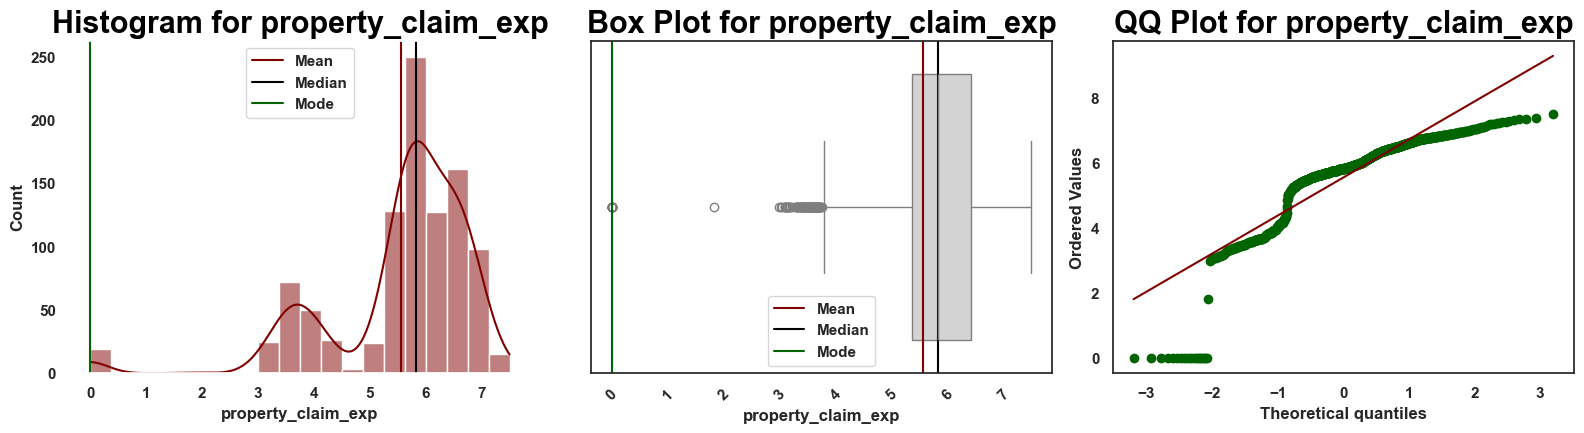



Skew for property_claim_exp is -1.87

Kurtosis for property_claim_exp is 4.76




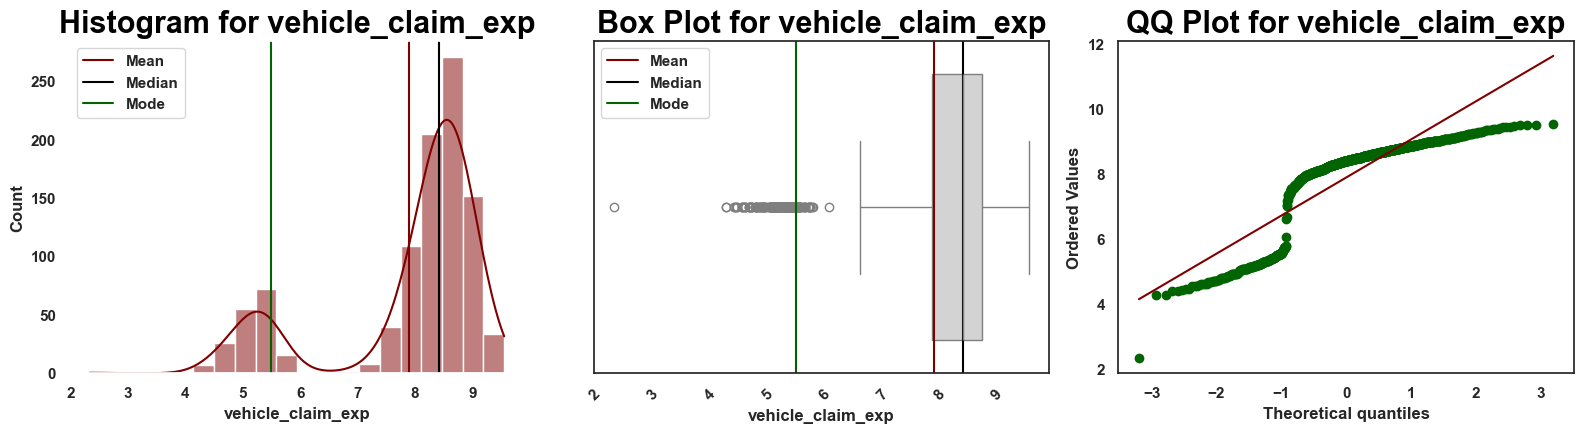



Skew for vehicle_claim_exp is -1.43

Kurtosis for vehicle_claim_exp is 0.69




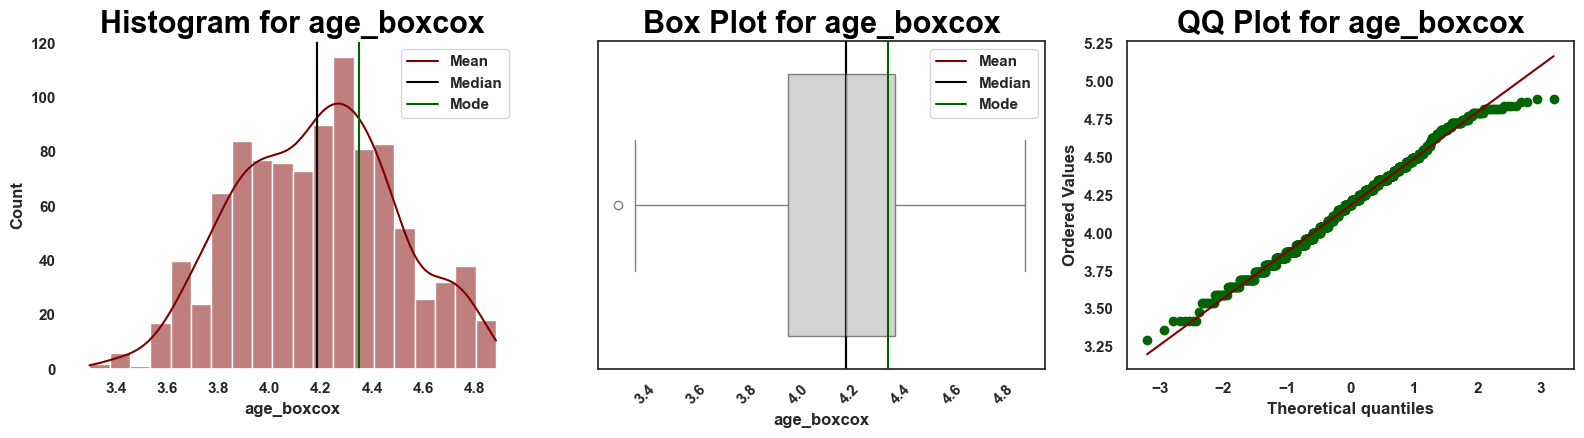



Skew for age_boxcox is -0.00

Kurtosis for age_boxcox is -0.49




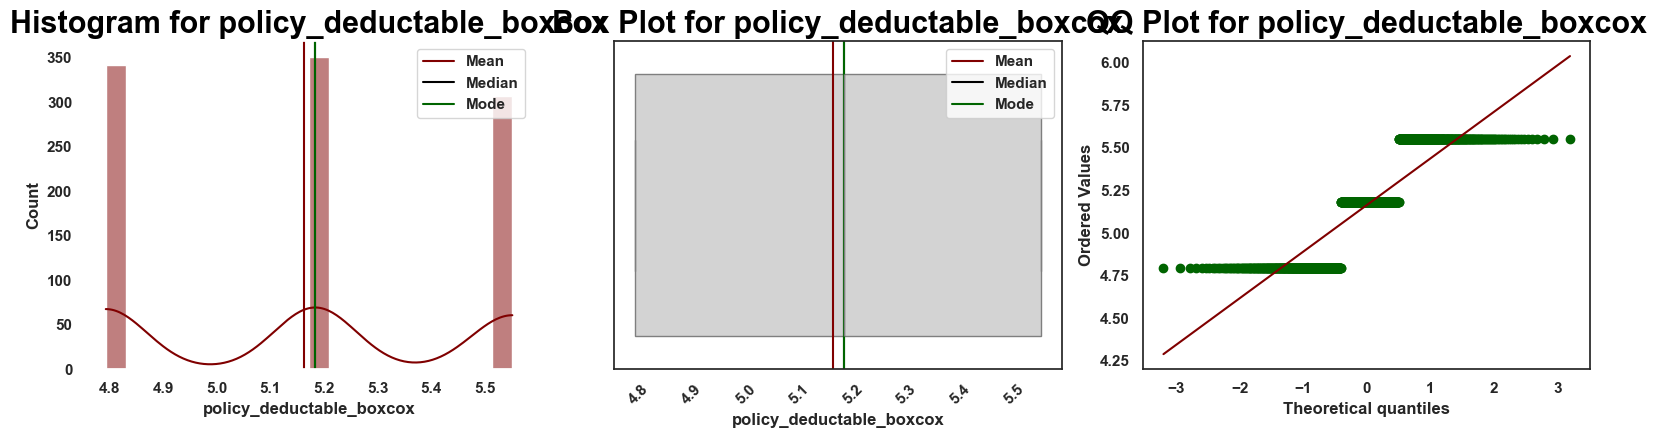



Skew for policy_deductable_boxcox is 0.02

Kurtosis for policy_deductable_boxcox is -1.46




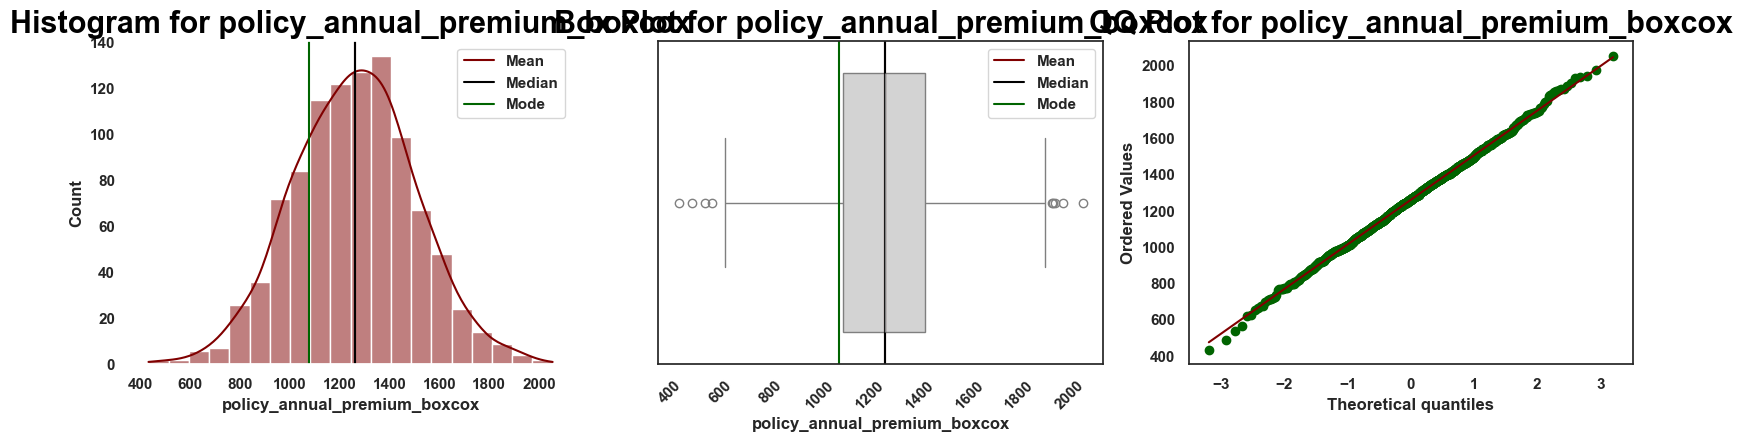



Skew for policy_annual_premium_boxcox is 0.00

Kurtosis for policy_annual_premium_boxcox is 0.07




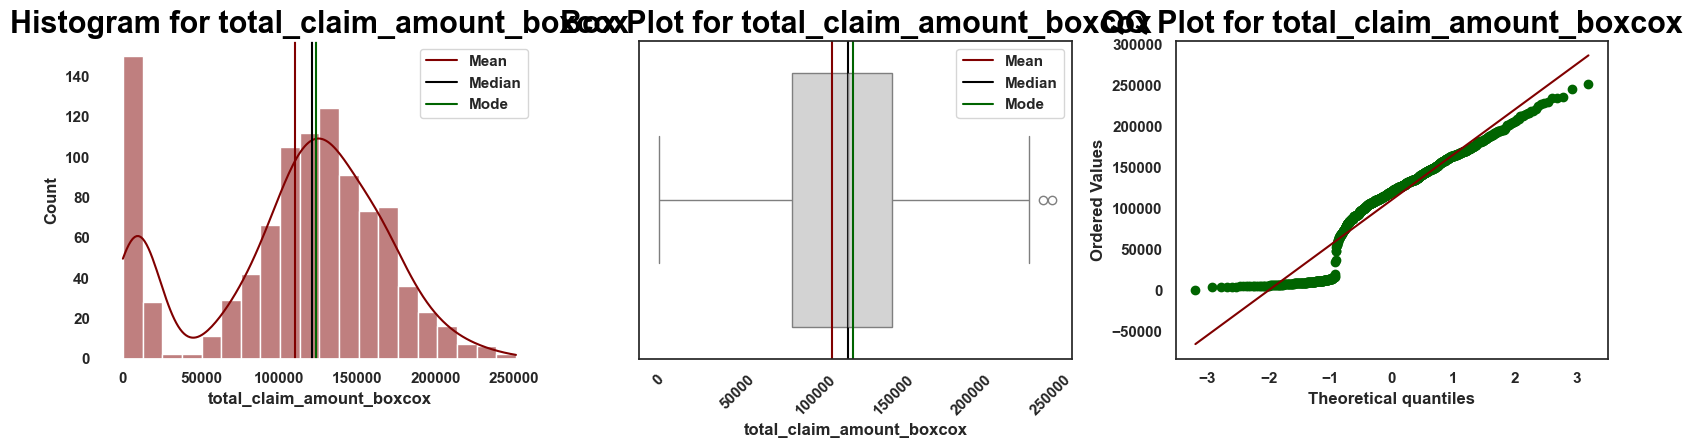



Skew for total_claim_amount_boxcox is -0.51

Kurtosis for total_claim_amount_boxcox is -0.49




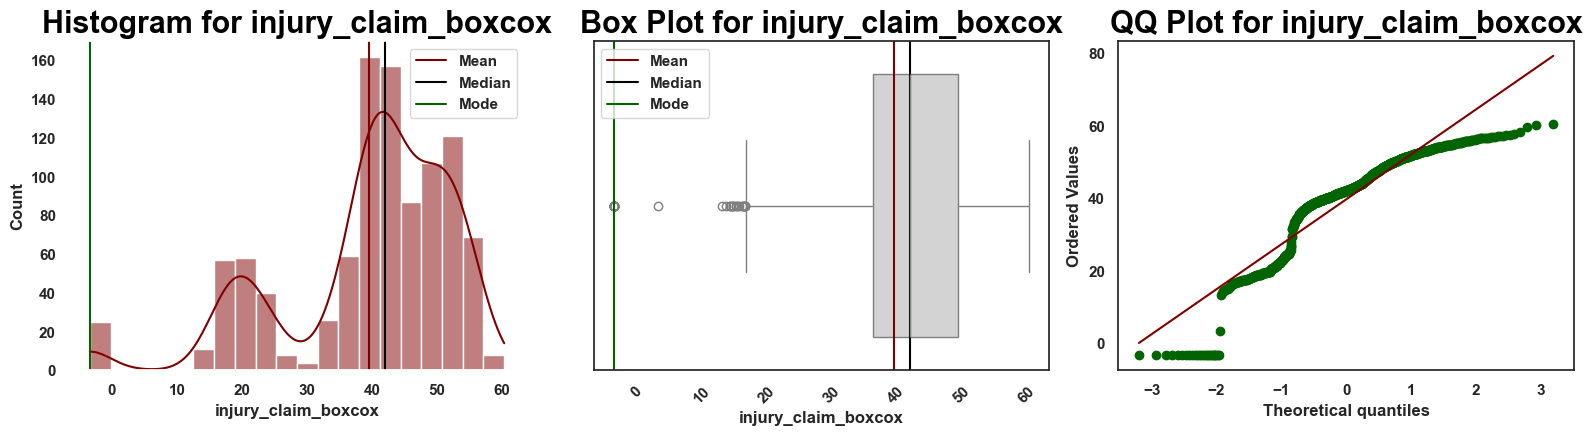



Skew for injury_claim_boxcox is -1.21

Kurtosis for injury_claim_boxcox is 1.26




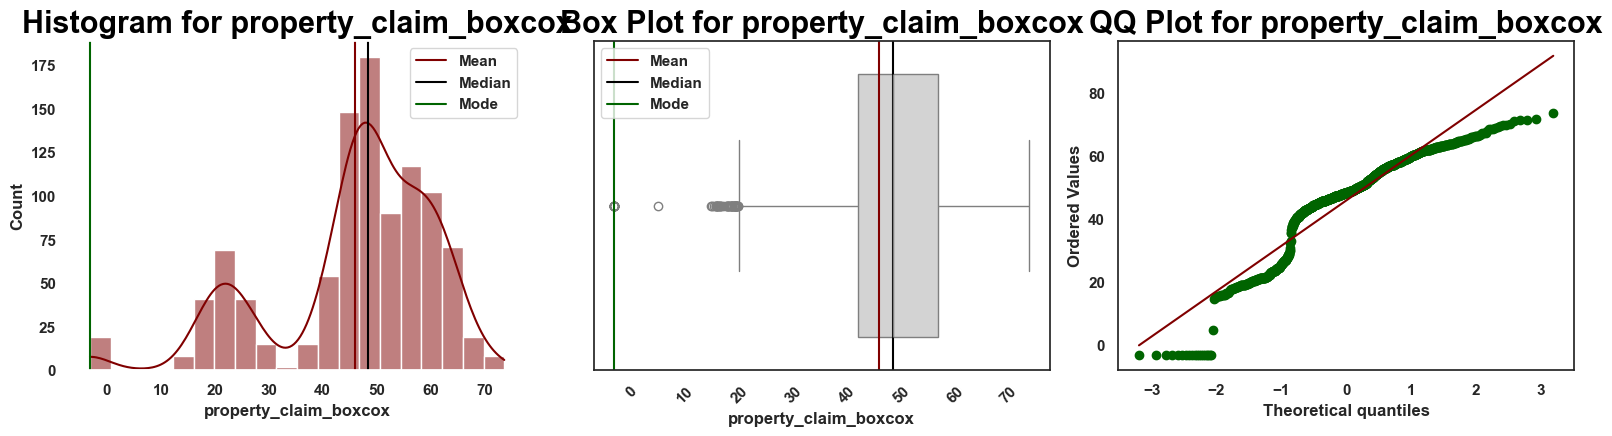



Skew for property_claim_boxcox is -1.06

Kurtosis for property_claim_boxcox is 0.85




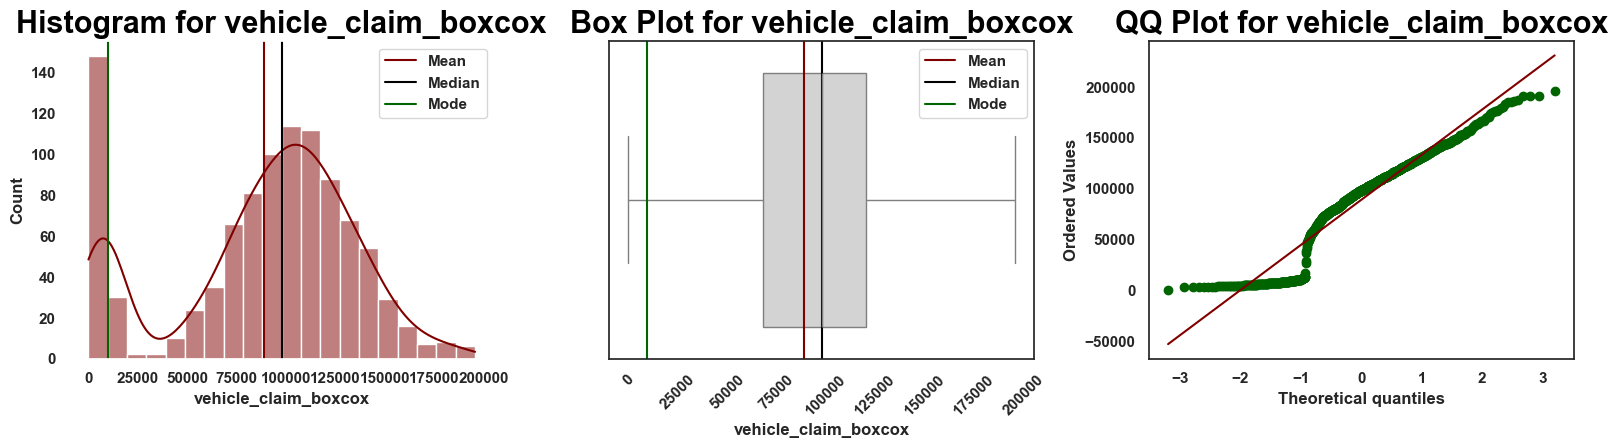



Skew for vehicle_claim_boxcox is -0.52

Kurtosis for vehicle_claim_boxcox is -0.49


Skewness:
 {'age_log': np.float64(-0.043079461360573), 'policy_deductable_log': np.float64(0.06350514691132216), 'policy_annual_premium_log': np.float64(-0.718712586578486), 'total_claim_amount_log': np.float64(-1.661258111293983), 'injury_claim_log': np.float64(-5.886737067056344), 'property_claim_log': np.float64(-6.75182687778129), 'vehicle_claim_log': np.float64(-1.6717339559561781), 'age_square': np.float16(0.2206), 'policy_deductable_square': np.float32(0.28620133), 'policy_annual_premium_square': np.float64(-0.32917370041309907), 'total_claim_amount_square': np.float64(-1.1311557725508745), 'injury_claim_square': np.float32(-0.55144984), 'property_claim_square': np.float32(-0.52344483), 'vehicle_claim_square': np.float64(-1.1462796987102333), 'age_rec': np.float64(0.5998445665467627), 'policy_deductable_rec': np.float64(0.33865156021406884), 'policy_annual_premium_rec': np.float64(1.8551417118

In [10]:
transformed_skewness = {}
transformed_kurtosis = {}
for i in normalized_df.columns:
    univar_num(normalized_df,i)
    skews=normalized_df[i].skew()
    kurt=normalized_df[i].kurtosis()
    transformed_skewness.update({i:skews})
    transformed_kurtosis.update({i:kurt})
    color = color_neutral
    if -0.5 <= skews <= 0.5:
        color = color_good  # Dark Green for near-zero skew
    elif 0 < skews <= 0.5 or -0.5 < skews < 0:
        color = color_okay  # Light Green for slightly positive or slightly negative skew
    else:  # skew_val > 0.5 or skew_val < -0.5
        color = color_bad  # Maroon for significant skew
      
    print(f"\n\n{color}Skew for {i} is {skews:.2f}{color_neutral}")    
    print(f"\n{color}Kurtosis for {i} is {kurt:.2f}{color_neutral}\n\n")
print( 'Skewness:\n',transformed_skewness,'\n\n','Kurtois:\n',transformed_kurtosis)


<span style="color: Chartreuse;font-size:150%">   &#9784; </span> <span style="color: Tomato;font-size: 120%;background-color:"> <b> Based on the skewness and kurtosis values, and distribution i have selected best transformation methods</span>

### <p Style="color: Khaki"> Creating the list of transformed features names:

In [11]:
transformed_features = [
    'age_boxcox',
    'policy_annual_premium_boxcox',
    'total_claim_amount_boxcox',
    'injury_claim_cube',
    'property_claim_cube',
    'vehicle_claim_boxcox',
]

original_features = [
    'age',
    'policy_annual_premium',
    'total_claim_amount',
    'injury_claim',
    'property_claim',
    'vehicle_claim',
]

### <p Style="color: Khaki"> Adding transformed features to our dataframe:

In [15]:
df[transformed_features] = normalized_df[transformed_features]
df.drop(original_features,axis=1,inplace=True)

In [16]:
df.sample(3)

months_as_customer policy_bind_date policy_state  policy_deductable  \
438                 211       1991-04-25           IL               1000   
889                 191       2005-11-20           IL               2000   
880                 121       1991-02-11           IN                500   

    insured_sex insured_education_level insured_occupation insured_hobbies  \
438      FEMALE                     PhD      other-service        sleeping   
889      FEMALE                 Masters       craft-repair        sleeping   
880        MALE                      MD    priv-house-serv     video-games   

    insured_relationship incident_date             incident_type  \
438            own-child    2015-01-12             Vehicle Theft   
889        not-in-family    2015-02-07   Multi-vehicle Collision   
880                 wife    2015-01-21  Single Vehicle Collision   

      collision_type incident_severity authorities_contacted incident_state  \
438           Others    Trivial Damage                Police             WV   
889   Side Collision      Major Damage             Ambulance             VA   
880  Front Collision      Major Damage                  Fire             VA   

    incident_city incident_hour_of_the_day number_of_vehicles_involved  \
438    Northbrook                        3                           1   
889     Hillsdale                       19                           3   
880    Northbrook                       11                           1   

    property_damage bodily_injuries witnesses police_report_available  \
438              NO               1         1                      NO   
889              NO               2         0                      NO   
880              NO               1         1                      NO   

      auto_make auto_year fraud_reported  age_boxcox  \
438        Audi      2004              N      4.2527   
889  Volkswagen      2007              N      4.1851   
880       Dodge      2000              Y      4.0394   

     policy_annual_premium_boxcox  total_claim_amount_boxcox  \
438                     1580.5950                  5363.3234   
889                     1256.8374                116846.9968   
880                     1288.9481                141459.0782   

     injury_claim_cube  property_claim_cube  vehicle_claim_boxcox  
438              11328                 9608             4192.1891  
889                  0                    0            95078.7936  
880             -22808               -22808           127991.1370

In [17]:
df.to_feather('transfered_data.feather')

## <span style="color:Aqua;"> Encoding Categorical Features:</span> 

### <span style="color:Khaki;">Reading capped Dataset:

In [18]:
df=pd.read_feather('transfered_data.feather')
df.sample(3)

months_as_customer policy_bind_date policy_state  policy_deductable  \
136                 200       2010-05-11           IL               1000   
608                 267       2004-08-09           OH               2000   
364                 291       2006-04-13           OH               1000   

    insured_sex insured_education_level insured_occupation insured_hobbies  \
136      FEMALE             High School              sales        exercise   
608      FEMALE                      MD       adm-clerical            polo   
364      FEMALE             High School       adm-clerical            polo   

    insured_relationship incident_date            incident_type  \
136       other-relative    2015-01-01            Vehicle Theft   
608                 wife    2015-01-06  Multi-vehicle Collision   
364            own-child    2015-01-25               Parked Car   

      collision_type incident_severity authorities_contacted incident_state  \
136           Others      Minor Damage                Police             VA   
608  Front Collision        Total Loss                Police             VA   
364           Others      Minor Damage                Police             SC   

    incident_city incident_hour_of_the_day number_of_vehicles_involved  \
136     Riverwood                        9                           1   
608     Riverwood                        4                           4   
364     Hillsdale                        8                           1   

    property_damage bodily_injuries witnesses police_report_available  \
136             YES               0         0                      NO   
608              NO               2         1                     YES   
364              NO               2         2                      NO   

      auto_make auto_year fraud_reported  age_boxcox  \
136        Ford      2015              N      4.2527   
608  Volkswagen      1996              N      4.4382   
364  Volkswagen      2005              Y      4.4382   

     policy_annual_premium_boxcox  total_claim_amount_boxcox  \
136                     1443.5035                  6270.5819   
608                     1550.6195                163678.1533   
364                      997.0982                  9774.2080   

     injury_claim_cube  property_claim_cube  vehicle_claim_boxcox  
136             -22872               -22872             5283.3294  
608             -29760               -11912           128327.1540  
364             -26432               -26432             8283.1945

## <span style="color:Aqua;">Defining variable type</span> 

In [25]:
ordinal = ['insured_education_level','incident_severity','witnesses','bodily_injuries',]

nominal = ['policy_state','insured_sex','insured_occupation','insured_hobbies','insured_relationship','incident_type',
           'collision_type','authorities_contacted','incident_state','incident_city','property_damage',
           'police_report_available','auto_make','fraud_reported']

discrete = ['months_as_customer','incident_hour_of_the_day','number_of_vehicles_involved','auto_year','policy_deductable']
continuous = [
    'age_boxcox','policy_annual_premium_boxcox','total_claim_amount_boxcox','injury_claim_cube',
    'property_claim_cube','vehicle_claim_boxcox',]

date = ['policy_bind_date','incident_date']

len(ordinal + nominal + discrete +continuous + date)

31

In [23]:
df.shape

(1000, 31)

## <span style="color:Aqua;"> Encoding Categorical Features:</span> 

### <span style="color:Khaki;">Creating Mapping dictionaries:

In [33]:
for col in continuous:
    print(df[age_boxcox].value_counts())

NameError: name 'age_boxcox' is not defined

In [125]:
Credit_Mix_map = { 'Poor': 0,'Bad':0, 'Standard':1, 'Good': 2  }
Payment_of_Min_Amount_map = { 'No':0, 'Nm':1, 'Yes':2 }
# Payment_Behaviour_map = { 'Low_Spent_Small_Value_Payments': 0 , 'Low_Spent_Medium_Value_Payments':1, 'Low_Spent_Large_Value_Payments':2,
#                          'High_Spent_Small_Value_Payments':3, 'High_Spent_Medium_Value_Payments':4, 'High_Spent_Large_Value_Payments':5
#                         }
age_group_map = {'<18': 0, '18-25': 1, '26-35': 2, '36-50': 3, '50+': 4,}

In [126]:
df['credit_mix'] = pd.to_numeric(df['credit_mix'].map(Credit_Mix_map),downcast='integer')
df['payment_of_min_amount'] = pd.to_numeric(df['payment_of_min_amount'].map(Payment_of_Min_Amount_map),downcast='integer')
# df['payment_behaviour'] = pd.to_numeric(df['payment_behaviour'].map(Payment_Behaviour_map),downcast='integer')
df['credit_score'] = pd.to_numeric(df['credit_score'].map(Credit_Mix_map),downcast='integer')
df['age_group'] = pd.to_numeric(df['age_group'].map(age_group_map),downcast='integer')
Payment_Behaviour_onehot = pd.get_dummies(df['payment_behaviour'],dtype='int8')

In [127]:
df= pd.concat([df,Payment_Behaviour_onehot],axis=1)

In [128]:
for col in ordinal:
    print(df[col].value_counts())

credit_mix
1    45848
2    30384
0    23768
Name: count, dtype: int64
payment_of_min_amount
2    52326
0    35667
1    12007
Name: count, dtype: int64
payment_behaviour
Low_Spent_Small_Value_Payments      28616
High_Spent_Medium_Value_Payments    19738
High_Spent_Large_Value_Payments     14726
Low_Spent_Medium_Value_Payments     14399
High_Spent_Small_Value_Payments     11764
Low_Spent_Large_Value_Payments      10757
Name: count, dtype: int64
credit_score
1    53174
0    28998
2    17828
Name: count, dtype: int64
age_group
3    35483
2    29142
1    19850
0     8295
4     7230
Name: count, dtype: int64


In [129]:
df.describe()

num_bank_accounts  num_credit_card  num_of_loan  delay_from_due_date  \
count        100000.0000      100000.0000  100000.0000          100000.0000   
mean              5.3688           5.5336       3.5329              21.0814   
std               2.5933           2.0671       2.4464              14.8046   
min               0.0000           0.0000       0.0000               0.0000   
25%               3.0000           4.0000       2.0000              10.0000   
50%               5.0000           5.0000       3.0000              18.0000   
75%               7.0000           7.0000       5.0000              28.0000   
max              11.0000          11.0000       9.0000              62.0000   

       num_of_delayed_payment  num_credit_inquiries  credit_mix  \
count             100000.0000           100000.0000 100000.0000   
mean                  13.3131                5.7983      1.0662   
std                    6.2372                3.8678      0.7329   
min                    0.0000                0.0000      0.0000   
25%                    9.0000                3.0000      1.0000   
50%                   14.0000                5.0000      1.0000   
75%                   18.0000                8.0000      2.0000   
max                   25.0000               17.0000      2.0000   

       payment_of_min_amount  credit_score  credit_inquiry_per_loan  \
count            100000.0000   100000.0000              100000.0000   
mean                  1.1666        0.8883                   1.8403   
std                   0.9231        0.6751                   1.2931   
min                   0.0000        0.0000                   0.0000   
25%                   0.0000        0.0000                   1.0000   
50%                   2.0000        1.0000                   2.0000   
75%                   2.0000        1.0000                   2.0000   
max                   2.0000        2.0000                  12.0000   

        age_group  disposable_income  age_boxcox  annual_income_boxcox  \
count 100000.0000        100000.0000 100000.0000           100000.0000   
mean       2.1350          4089.5716     11.3209               13.8608   
std        1.0752          3132.9336      2.5192                1.3315   
min        0.0000          -863.3358      6.2613               11.1147   
25%        1.0000          1579.0700      9.2002               12.7298   
50%        2.0000          3016.5687     11.4226               13.8046   
75%        3.0000          5785.1548     13.4018               14.9368   
max        4.0000         15101.9400     16.1564               16.5758   

       monthly_inhand_salary_boxcox  interest_rate_boxcox  \
count                   100000.0000           100000.0000   
mean                        11.5786                5.2516   
std                          1.5771                2.4293   
min                          7.3500                0.0000   
25%                         10.2746                3.2999   
50%                         11.5109                5.2293   
75%                         12.8393                6.9734   
max                         14.8732                9.7112   

       outstanding_debt_square  credit_utilization_ratio_log  \
count              100000.0000                   100000.0000   
mean                   34.6016                        3.4457   
std                    15.1312                        0.1644   
min                     0.4796                        2.9957   
25%                    23.7923                        3.3322   
50%                    34.1490                        3.4657   
75%                    44.1131                        3.5835   
max                    70.6970                        3.9120   

       credit_history_age_boxcox  changed_credit_limit_cube  \
count                100000.0000                100000.0000   
mean                    124.3568                     5.5901   
std                      50.7896                    57.1509   
min  

In [130]:
df.drop('payment_behaviour',axis=1,inplace=True)
df.sample(3)

num_bank_accounts  num_credit_card  num_of_loan  delay_from_due_date  \
14836                  5                7            5                   26   
38352                  7                3            2                   12   
71995                  1                6            1                    8   

       num_of_delayed_payment  num_credit_inquiries  credit_mix  \
14836                      21                4.0000           1   
38352                      15                4.0000           2   
71995                       4                4.0000           2   

       payment_of_min_amount  credit_score  credit_inquiry_per_loan  \
14836                      2             1                   1.0000   
38352                      0             2                   2.0000   
71995                      0             1                   2.0000   

       age_group  disposable_income  age_boxcox  annual_income_boxcox  \
14836          2          4531.4438     10.4710               14.5759   
38352          1          2894.9308      8.6613               13.6393   
71995          3          1744.1296     15.0159               12.9649   

       monthly_inhand_salary_boxcox  interest_rate_boxcox  \
14836                       12.3336                6.9734   
38352                       11.4026                4.3379   
71995                       10.4180                4.9448   

       outstanding_debt_square  credit_utilization_ratio_log  \
14836                  34.7618                        3.5553   
38352                  28.0605                        3.5553   
71995                  21.6878                        3.4965   

       credit_history_age_boxcox  changed_credit_limit_cube  \
14836                    70.7193                        -64   
38352                   180.0122                        -40   
71995                   131.8837                         51   

       total_emi_per_month_square  amount_invested_monthly_boxcox  \
14836                     11.4928                         11.5774   
38352                      5.9443                          6.7227   
71995                      3.4219                          4.6723   

       monthly_balance_boxcox  credit_limit_change_rate_exp  \
14836                 16.6290                        0.6352   
38352                 22.9032                        0.4479   
71995                 20.5211                        0.5425   

       debt_income_ratio_log  loan_income_ratio_month_boxcox  \
14836                 8.4066                          1.8564   
38352                 8.6285                          2.0169   
71995                 7.9342                          2.0945   

       credit_utilization_per_account_boxcox  reliable_payment_boxcox  \
14836                                 0.9710                   4.0047   
38352                                 0.8869                   1.7748   
71995                                 1.1589                   0.5724   

       delayed_payment_ratio_boxcox  investment_to_income_ratio_square  \
14836                        1.5202                             0.1620   
38352                        2.0681                             0.1099   
71995                        0.7704                             0.0989   

       total_credit_exposure_boxcox  \
14836                       25.9713   
38352                       22.4729   
71995                       18.8584   

       credit_utilization_to_income_ratio_boxcox  savings_rate_rec  \
14836                                   -10.0163           38.0759   
38352                                    -9.0584           82.6929   
71995                                    -8.4749          102.1436   

       income_stability_boxcox  total_liability_boxcox  debt_paytime_log  \
14836                  -0.0383                 26.6691            2.2061   
38352                   0.0487                 22.4856            3.0759   
71995                  -0.0564               

In [131]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 42 columns):
 #   Column                                     Non-Null Count   Dtype  
---  ------                                     --------------   -----  
 0   num_bank_accounts                          100000 non-null  int8   
 1   num_credit_card                            100000 non-null  int8   
 2   num_of_loan                                100000 non-null  int8   
 3   delay_from_due_date                        100000 non-null  int8   
 4   num_of_delayed_payment                     100000 non-null  int8   
 5   num_credit_inquiries                       100000 non-null  float64
 6   credit_mix                                 100000 non-null  int8   
 7   payment_of_min_amount                      100000 non-null  int8   
 8   credit_score                               100000 non-null  int8   
 9   credit_inquiry_per_loan                    100000 non-null  float64
 10  age_group

In [133]:
df.to_feather('model_ready.feather')
df.sample(3)

num_bank_accounts  num_credit_card  num_of_loan  delay_from_due_date  \
26500                  3                3            3                   21   
33498                  3                9            6                   11   
47076                  7                7            7                   40   

       num_of_delayed_payment  num_credit_inquiries  credit_mix  \
26500                       9                2.0000           1   
33498                      12               12.0000           1   
47076                      24                6.0000           0   

       payment_of_min_amount  credit_score  credit_inquiry_per_loan  \
26500                      0             1                   1.0000   
33498                      2             0                   2.0000   
47076                      1             0                   1.0000   

       age_group  disposable_income  age_boxcox  annual_income_boxcox  \
26500          3          1299.4534     12.7638               12.2166   
33498          1          2891.5795      8.1014               13.6750   
47076          0          1488.5162      6.9059               12.8227   

       monthly_inhand_salary_boxcox  interest_rate_boxcox  \
26500                        9.9026                3.6669   
33498                       11.4654                8.0366   
47076                       10.2288                9.3602   

       outstanding_debt_square  credit_utilization_ratio_log  \
26500                  17.2772                        3.5264   
33498                  38.5448                        3.4657   
47076                  46.7034                        3.2958   

       credit_history_age_boxcox  changed_credit_limit_cube  \
26500                   113.7707                        -64   
33498                   129.8899                        -39   
47076                   131.8837                        -39   

       total_emi_per_month_square  amount_invested_monthly_boxcox  \
26500                      5.5955                          5.4802   
33498                     11.5691                          9.4395   
47076                      9.9329                          4.0303   

       monthly_balance_boxcox  credit_limit_change_rate_exp  \
26500                 20.5902                        0.5708   
33498                 20.9016                        0.5230   
47076                 18.9212                        0.5212   

       debt_income_ratio_log  loan_income_ratio_month_boxcox  \
26500                 7.6070                          1.8920   
33498                 7.6689                          1.7449   
47076                 7.2189                          1.6439   

       credit_utilization_per_account_boxcox  reliable_payment_boxcox  \
26500                                 1.0566                   1.7901   
33498                                 1.0444                   1.9816   
47076                                 0.7935                   3.0107   

       delayed_payment_ratio_boxcox  investment_to_income_ratio_square  \
26500                        0.9179                             0.1324   
33498                        0.5850                             0.1578   
47076                        1.3010                             0.0911   

       total_credit_exposure_boxcox  \
26500                       16.2041   
33498                       27.8248   
47076                       31.6357   

       credit_utilization_to_income_ratio_boxcox  savings_rate_rec  \
26500                                    -7.6777           57.0312   
33498                                    -9.2478           40.1622   
47076                                    -8.6643          120.5225   

       income_stability_boxcox  total_liability_boxcox  debt_paytime_log  \
26500                   0.1340                 16.1611            2.2234   
33498                   0.0599                 28.4671            2.3995   
47076                  -0.0697               